# 1. Imports

In [2]:
import numpy as np
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from sklearn.linear_model import LinearRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# 2. Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
features_with_polarization_20 = pd.read_pickle('/content/drive/MyDrive/final_features_scores_20.pkl')
features_with_polarization_20

,id,electoral_term,session,first_name,document_url,last_name,faction_id,position_short,position_long,politician_id,...,topic,main_category,sub_category,Stadt,Former Country,City Classification,net_sentiment_score,positivity_sentiment,negativity_sentiment,polarizing
100032,1066957,20,1,gabriele,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,katzmarek,25,Member of Parliament,None,11004325,...,No Topic,no topic,None,Marl,former BRD,Medium City,0.285714,0.285714,0.000000,False
100033,1066959,20,1,gabriele,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,katzmarek,25,Member of Parliament,None,11004325,...,Binnenhandel: Verbraucherschutz,Domestic Trade,Verbraucherschutz,Marl,former BRD,Medium City,0.134146,0.176829,0.042683,False
100034,1066961,20,1,stefan,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,müller,5,Member of Parliament,None,11003597,...,Recht & Kriminalität,Law & Crime,None,NaN,NaN,NaN,0.074219,0.128906,0.054688,False
100035,1066963,20,1,britta,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,haßelmann,4,Member of Parliament,None,11003764,...,Arbeit,Work,None,Straelen,former BRD,Small City,0.092527,0.138790,0.046263,False
100036,1066965,20,1,marco,https://dip21.bundestag.de/dip21/btp/20/20001.pdf,buschmann,15,Minister,Bundesminister der Justiz,11004023,...,Recht & Kriminalität,Law & Crime,None,Gelsenkirchen,former BRD,Large City,0.137255,0.183007,0.045752,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131053,1075918,20,187,karoline,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,otte,4,Member of Parliament,None,11005172,...,Öffentliche Verwaltung,Public Administration,None,Göttingen,former BRD,Large City,0.114428,0.194030,0.079602,False
131054,1075920,20,187,peter,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,aumer,5,Member of Parliament,None,11004004,...,"BürgerInnenrechte: Flucht, Asyl & Einbürgerung",Civil Rights,"Flucht, Asyl & Einbürgerung",Regensburg,former BRD,Large City,0.076000,0.136000,0.060000,True
131055,1075922,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,0,Member of Parliament,None,11004891,...,BürgerInnenrechte,Civil Rights,None,Ettenheim,former BRD,Small City,0.030534,0.099237,0.068702,True
131056,1075924,20,187,thomas,https://dip21.bundestag.de/dip21/btp/20/20187.pdf,seitz,18,Member of Parliament,None,11004891,...,No Topic,no topic,None,Ettenheim,former BRD,Small City,0.500000,0.500000,0.000000,False


In [5]:
features_with_polarization_20.columns

Index(['id', 'electoral_term', 'session', 'first_name', 'document_url',
       'last_name', 'faction_id', 'position_short', 'position_long',
       'politician_id', 'top_item', 'top_title', 'speech_content', 'date',
       'faction', 'year', 'speech_length', 'age', 'gender', 'tenure', 'topic',
       'main_category', 'sub_category', 'Stadt', 'Former Country',
       'City Classification', 'net_sentiment_score', 'positivity_sentiment',
       'negativity_sentiment', 'polarizing'],
      dtype='object')

# 4. Trend Analysis

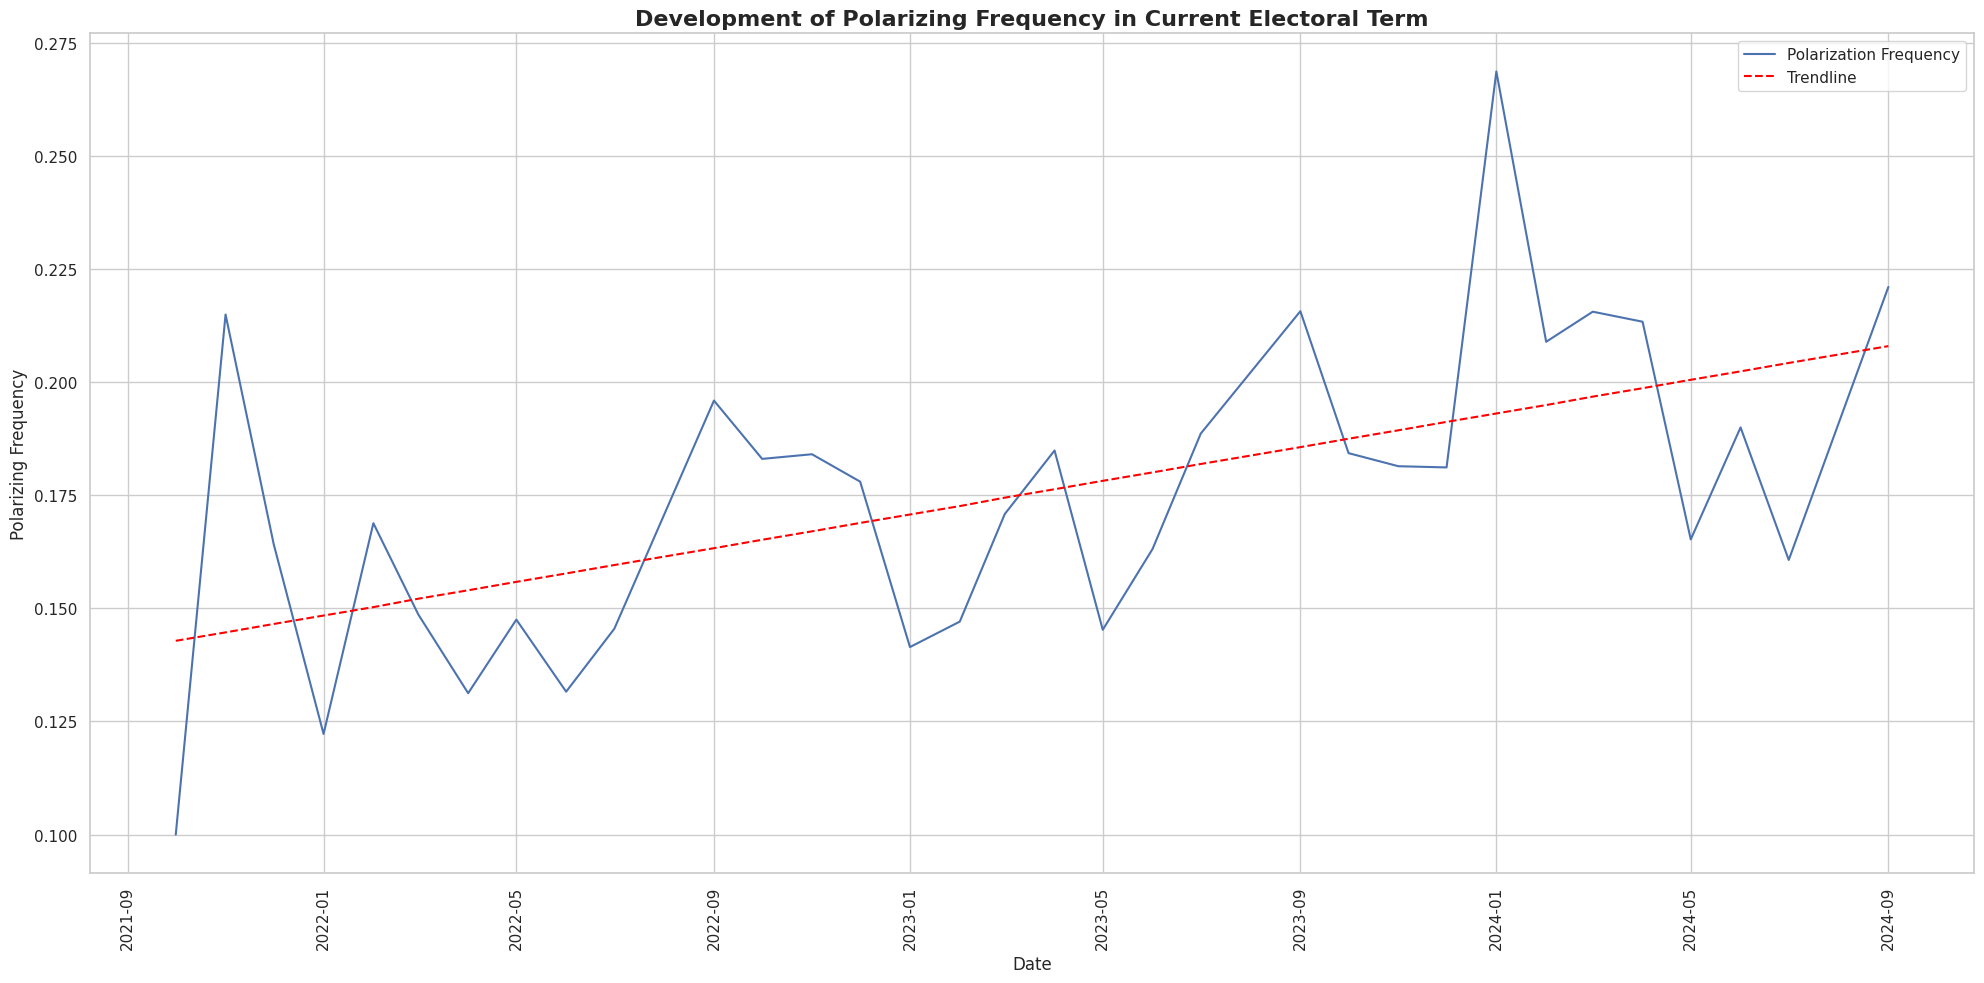

In [5]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M')

features_with_polarization_20_grouped = features_with_polarization_20.groupby('month_year').agg({'polarizing':'sum', 'id':'count'}).reset_index()

features_with_polarization_20_grouped['polarizing_frequency'] = features_with_polarization_20_grouped['polarizing']/features_with_polarization_20_grouped['id']

features_with_polarization_20_grouped['month_year'] = features_with_polarization_20_grouped['month_year'].dt.to_timestamp()

features_with_polarization_20_grouped['time_index'] = (features_with_polarization_20_grouped['month_year'].dt.year - features_with_polarization_20_grouped['month_year'].dt.year.min()) * 12 + features_with_polarization_20_grouped['month_year'].dt.month

X = features_with_polarization_20_grouped['time_index'].values.reshape(-1, 1)
y = features_with_polarization_20_grouped['polarizing_frequency'].values

model = LinearRegression()
model.fit(X, y)
sns.set_theme(style="whitegrid")

trendline = model.predict(X)

# Zuwachsrate berechnen (in %)
growth_rate_percent = model.coef_[0] * 100

# Plot erstellen
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))

# Originalwerte und Trendlinie plotten
plt.plot(features_with_polarization_20_grouped['month_year'], features_with_polarization_20_grouped['polarizing_frequency'], label='Polarization Frequency')
plt.plot(features_with_polarization_20_grouped['month_year'], trendline, label='Trendline', color='red', linestyle='--')

# Achsenbeschriftungen und Titel
plt.xlabel('Date')
plt.ylabel('Polarizing Frequency')
plt.title('Development of Polarizing Frequency in Current Electoral Term', fontsize=16, weight='bold')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()



In [29]:
slope = model.coef_[0]
slope

0.0018603516393299016

# 5. Analysis by parties

## 5.1 Analysis by all Parties

In [7]:
# Define color map for factions
color_map = {
    'CDU/CSU': 'black',
    'SPD': 'red',
    'FDP': 'yellow',
    'Bündnis 90/Die Grünen': 'green',
    'DIE LINKE.': 'purple',
    'AfD': 'blue',
    'BSW': 'pink'
}


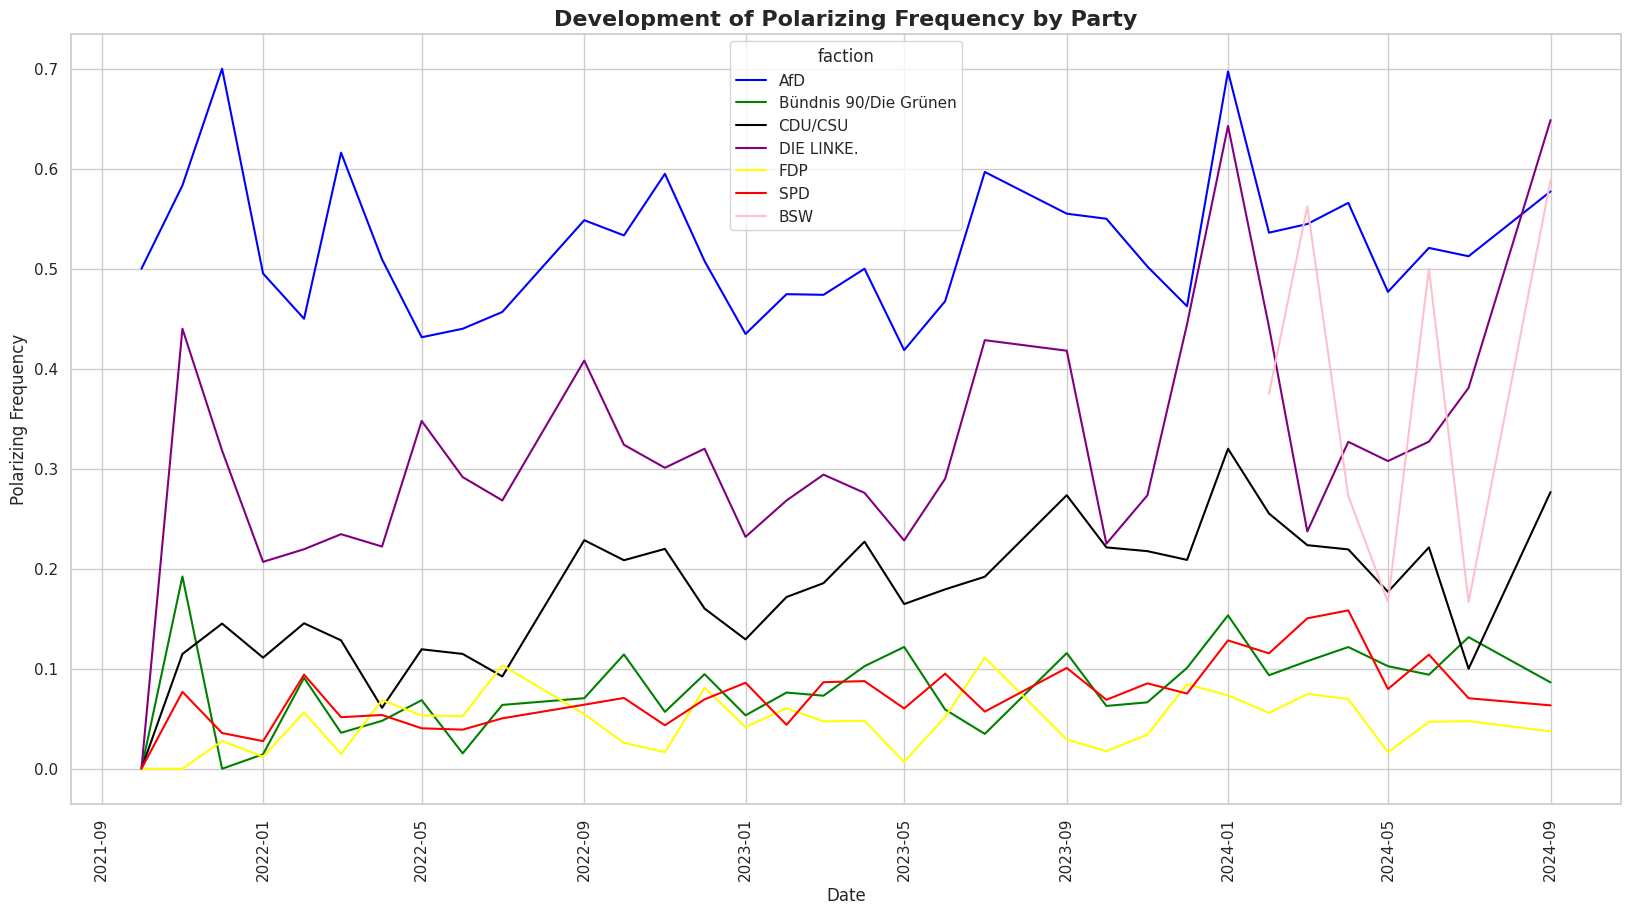

In [11]:
features_with_polarization_20_grouped_faction = features_with_polarization_20.groupby(['month_year', 'faction']).agg({'polarizing':'sum', 'id':'count'}).reset_index()

features_with_polarization_20_grouped_faction = features_with_polarization_20_grouped_faction[features_with_polarization_20_grouped_faction['faction'] != 'Fraktionslos']


features_with_polarization_20_grouped_faction['polarizing_frequency'] = features_with_polarization_20_grouped_faction['polarizing']/features_with_polarization_20_grouped_faction['id']

features_with_polarization_20_grouped_faction['month_year'] = features_with_polarization_20_grouped_faction['month_year'].dt.to_timestamp()
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20,10))
sns.lineplot(data=features_with_polarization_20_grouped_faction, x='month_year', y='polarizing_frequency', hue='faction', palette=color_map)
plt.xlabel('Date')
plt.ylabel('Polarizing Frequency')
plt.title('Development of Polarizing Frequency by Party', fontsize=16, weight='bold')
plt.xticks(rotation=90)
plt.show()


In [9]:
features_with_polarization_20_grouped_faction['moving_avg'] = features_with_polarization_20_grouped_faction.groupby('faction')['polarizing_frequency'].transform(
    lambda x: x.rolling(window=1, min_periods=1).mean()
)

average_moving_avg = features_with_polarization_20_grouped_faction.groupby('faction')['moving_avg'].mean().reset_index()

average_moving_avg = average_moving_avg.sort_values(by='moving_avg', ascending=False).reset_index(drop=True)

print("Durchschnittliche Moving Average pro Fraktion:")
print(average_moving_avg)


Durchschnittliche Moving Average pro Fraktion:
                 faction  moving_avg
0                    AfD    0.522255
1                    BSW    0.375971
2             DIE LINKE.    0.321014
3                CDU/CSU    0.176176
4  Bündnis 90/Die Grünen    0.079494
5                    SPD    0.074076
6                    FDP    0.046115


In [10]:
features_with_polarization_20_grouped_faction['time_index'] = (
    (features_with_polarization_20_grouped_faction['month_year'].dt.year - features_with_polarization_20_grouped_faction['month_year'].dt.year.min()) * 12
    + features_with_polarization_20_grouped_faction['month_year'].dt.month
)

trend_results = {}

for faction, group in features_with_polarization_20_grouped_faction.groupby('faction'):
    X = group['time_index'].values.reshape(-1, 1)
    y = group['polarizing_frequency'].values

    model = LinearRegression()
    model.fit(X, y)

    trend_results[faction] = model.coef_[0]

trend_df = pd.DataFrame(list(trend_results.items()), columns=['faction', 'trend_4_years'])

# Sortieren nach 'trend_4_years' in absteigender Reihenfolge
trend_df = trend_df.sort_values(by='trend_4_years', ascending=False).reset_index(drop=True)

print("Trend über die letzten 4 Jahre für jede Fraktion:")
print(trend_df)


Trend über die letzten 4 Jahre für jede Fraktion:
                 faction  trend_4_years
0                    BSW       0.008250
1             DIE LINKE.       0.005653
2                CDU/CSU       0.004312
3                    SPD       0.002090
4  Bündnis 90/Die Grünen       0.001840
5                    FDP       0.000674
6                    AfD       0.000430


## 5.2 Analysis Governing vs. Opposition

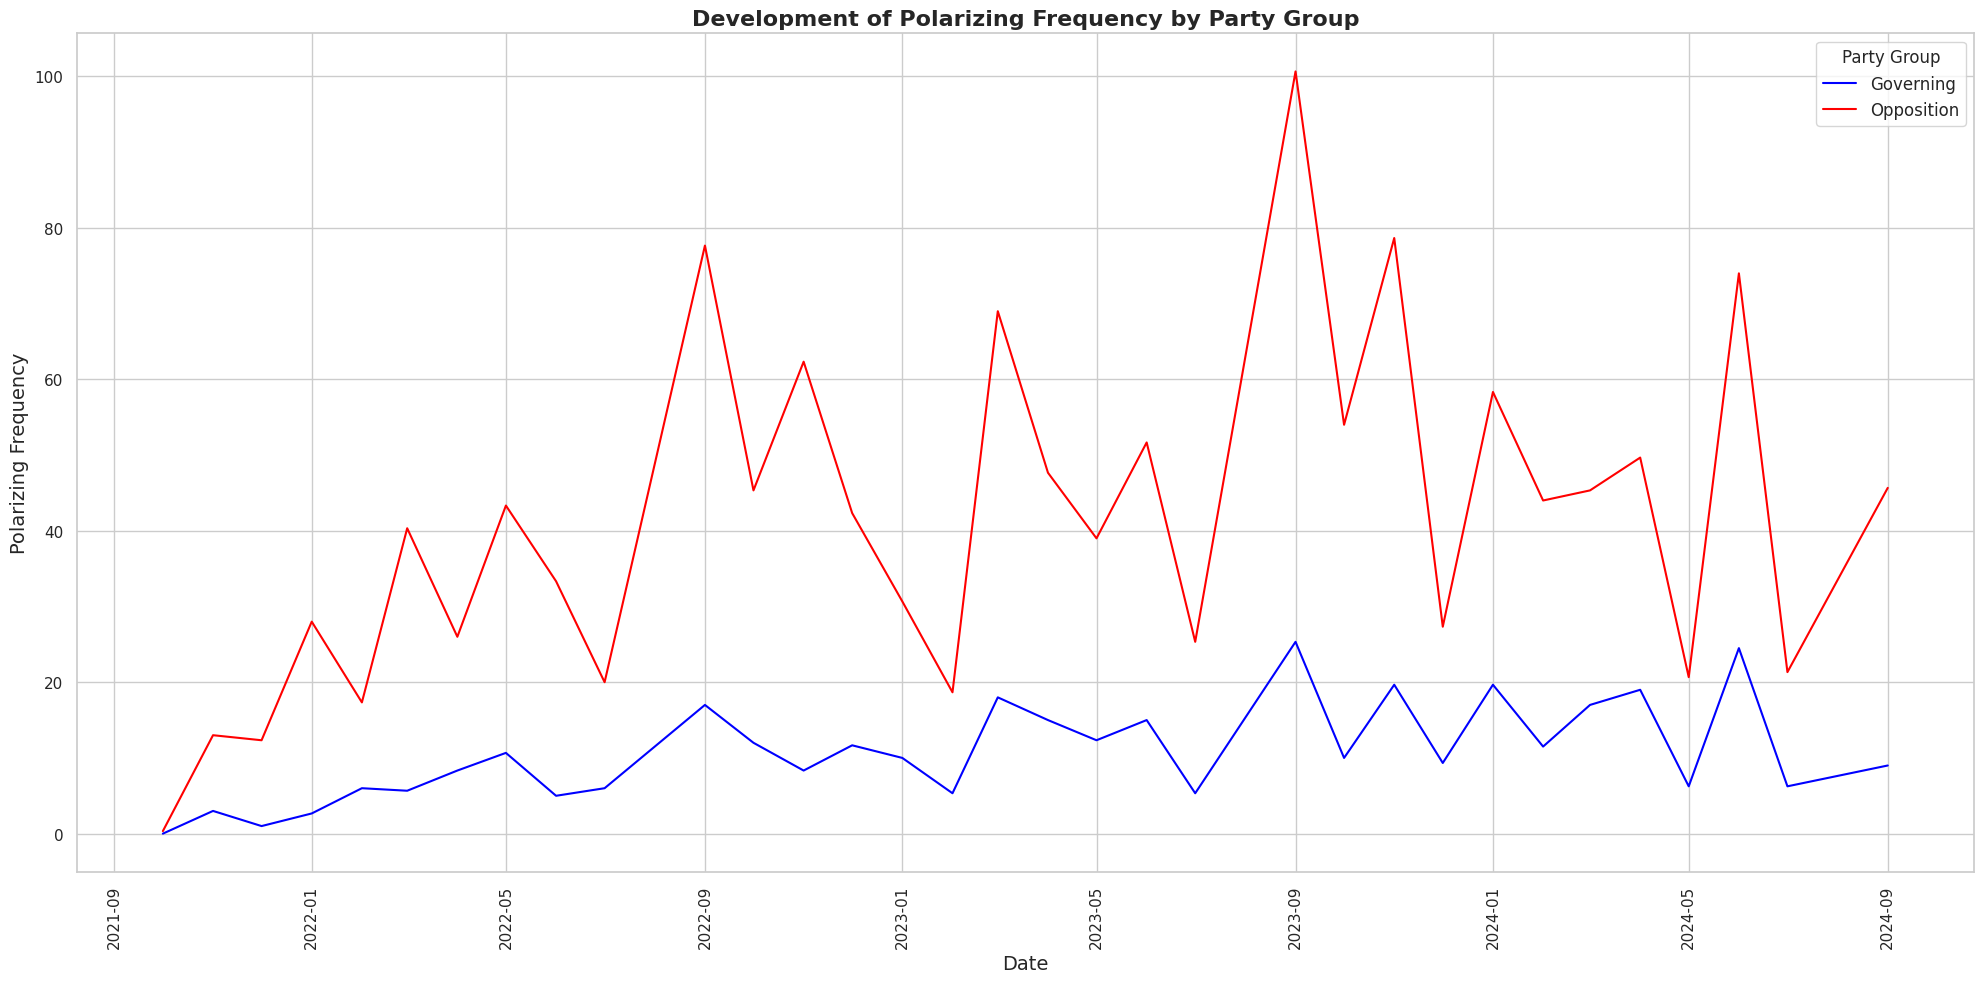

In [12]:
# Definiere die Gruppierung der Fraktionen in 'Governing' und 'Opposition'
governing_parties = ['SPD', 'Bündnis 90/Die Grünen', 'FDP', 'BSW']
opposition_parties = ['AfD', 'DIE LINKE.','CDU/CSU']

features_with_polarization_20_grouped_faction = features_with_polarization_20_grouped_faction[features_with_polarization_20_grouped_faction['faction'] != 'Fraktionslos']

features_with_polarization_20_grouped_faction['party_group'] = features_with_polarization_20_grouped_faction['faction'].apply(
    lambda x: 'Governing' if x in governing_parties else ('Opposition' if x in opposition_parties else 'Other'))

features_with_polarization_20_grouped_faction = features_with_polarization_20_grouped_faction.groupby(['month_year', 'party_group']).agg({'polarizing': 'sum', 'id': 'count'}).reset_index()

features_with_polarization_20_grouped_faction['polarizing_frequency'] = features_with_polarization_20_grouped_faction['polarizing'] / features_with_polarization_20_grouped_faction['id']
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 10))
sns.lineplot(data=features_with_polarization_20_grouped_faction, x='month_year', y='polarizing_frequency', hue='party_group', palette={'Governing': 'blue', 'Opposition': 'red'},)
plt.xticks(rotation=90)
plt.title("Development of Polarizing Frequency by Party Group", fontsize=16, weight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Polarizing Frequency", fontsize=14)
plt.legend(title='Party Group', fontsize=12)
plt.tight_layout()
plt.show()


# 6. Demographics

## 6.1 By Gender


In [15]:
# group by gender, sum polarizing, vizaulize
features_with_polarization_20_gender = features_with_polarization_20.groupby('gender').agg({'polarizing':'sum', 'id':'count'}).reset_index()

features_with_polarization_20_gender['polarizing_frequency'] = features_with_polarization_20_gender['polarizing']/features_with_polarization_20_gender['id']

features_with_polarization_20_gender

,gender,polarizing,id,polarizing_frequency
0,männlich,4155,20351,0.204167
1,weiblich,1394,9761,0.142813


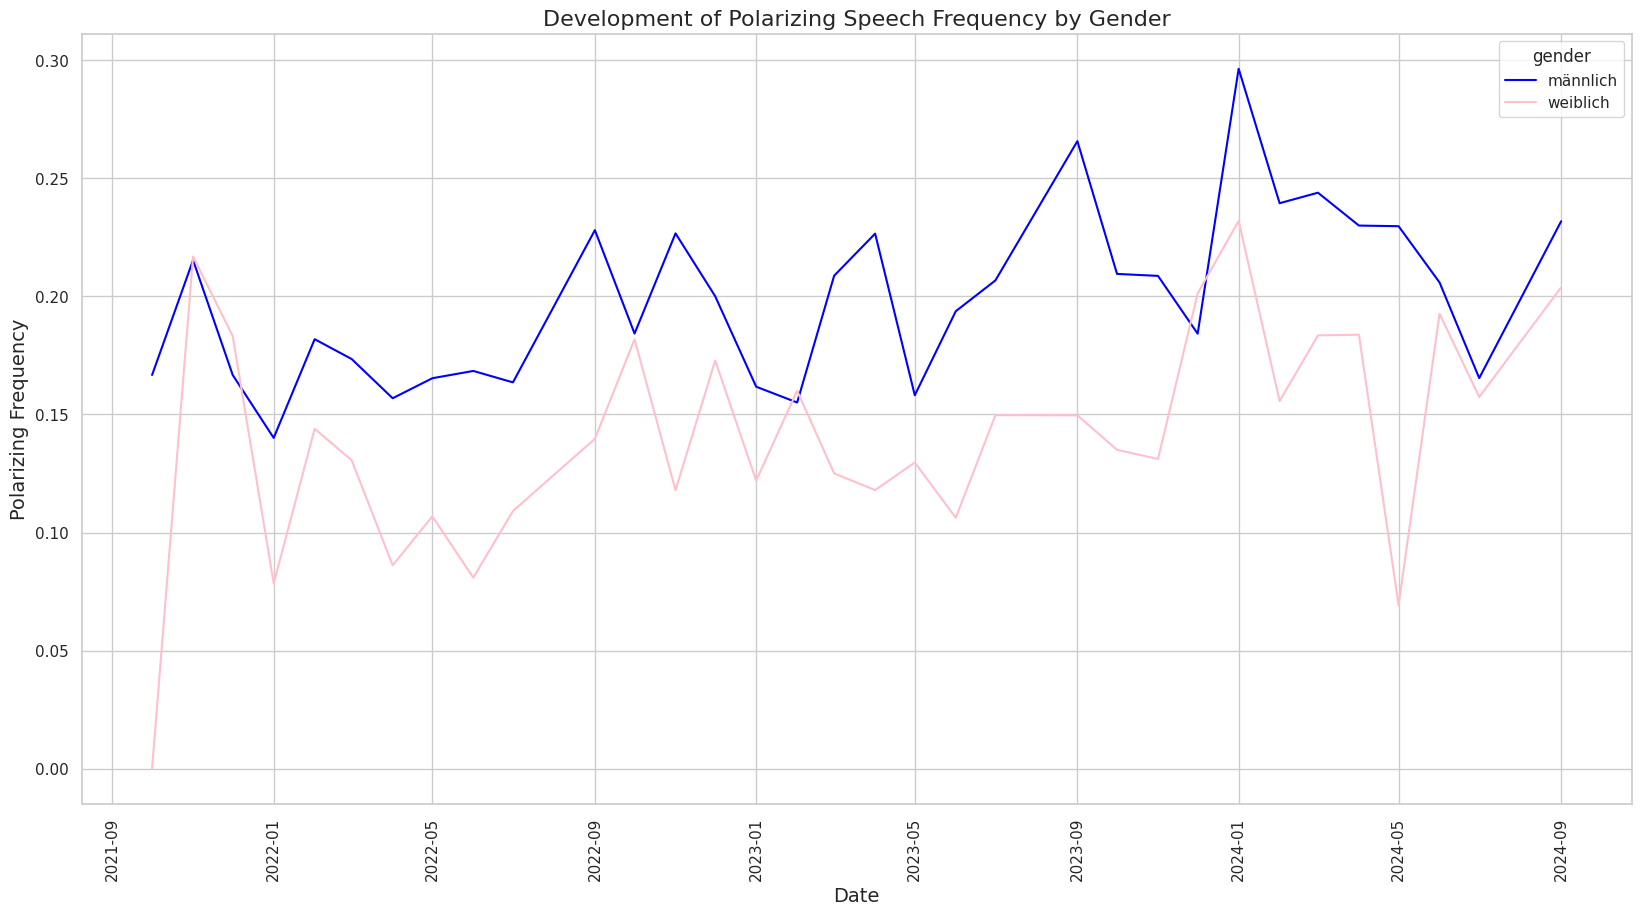

In [13]:
features_with_polarization_20_grouped_gender = features_with_polarization_20.groupby(['month_year', 'gender']).agg({'polarizing':'sum', 'id':'count'}).reset_index()

features_with_polarization_20_grouped_gender['polarizing_frequency'] = features_with_polarization_20_grouped_gender['polarizing']/features_with_polarization_20_grouped_gender['id']

features_with_polarization_20_grouped_gender['month_year'] = features_with_polarization_20_grouped_gender['month_year'].dt.to_timestamp()

palette = {'männlich': 'blue', 'weiblich': 'pink'}
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 10))
sns.lineplot(data=features_with_polarization_20_grouped_gender, x='month_year', y='polarizing_frequency', hue='gender', palette=palette)
plt.title("Development of Polarizing Speech Frequency by Gender", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Polarizing Frequency", fontsize=14)
plt.xticks(rotation=90)
plt.show()


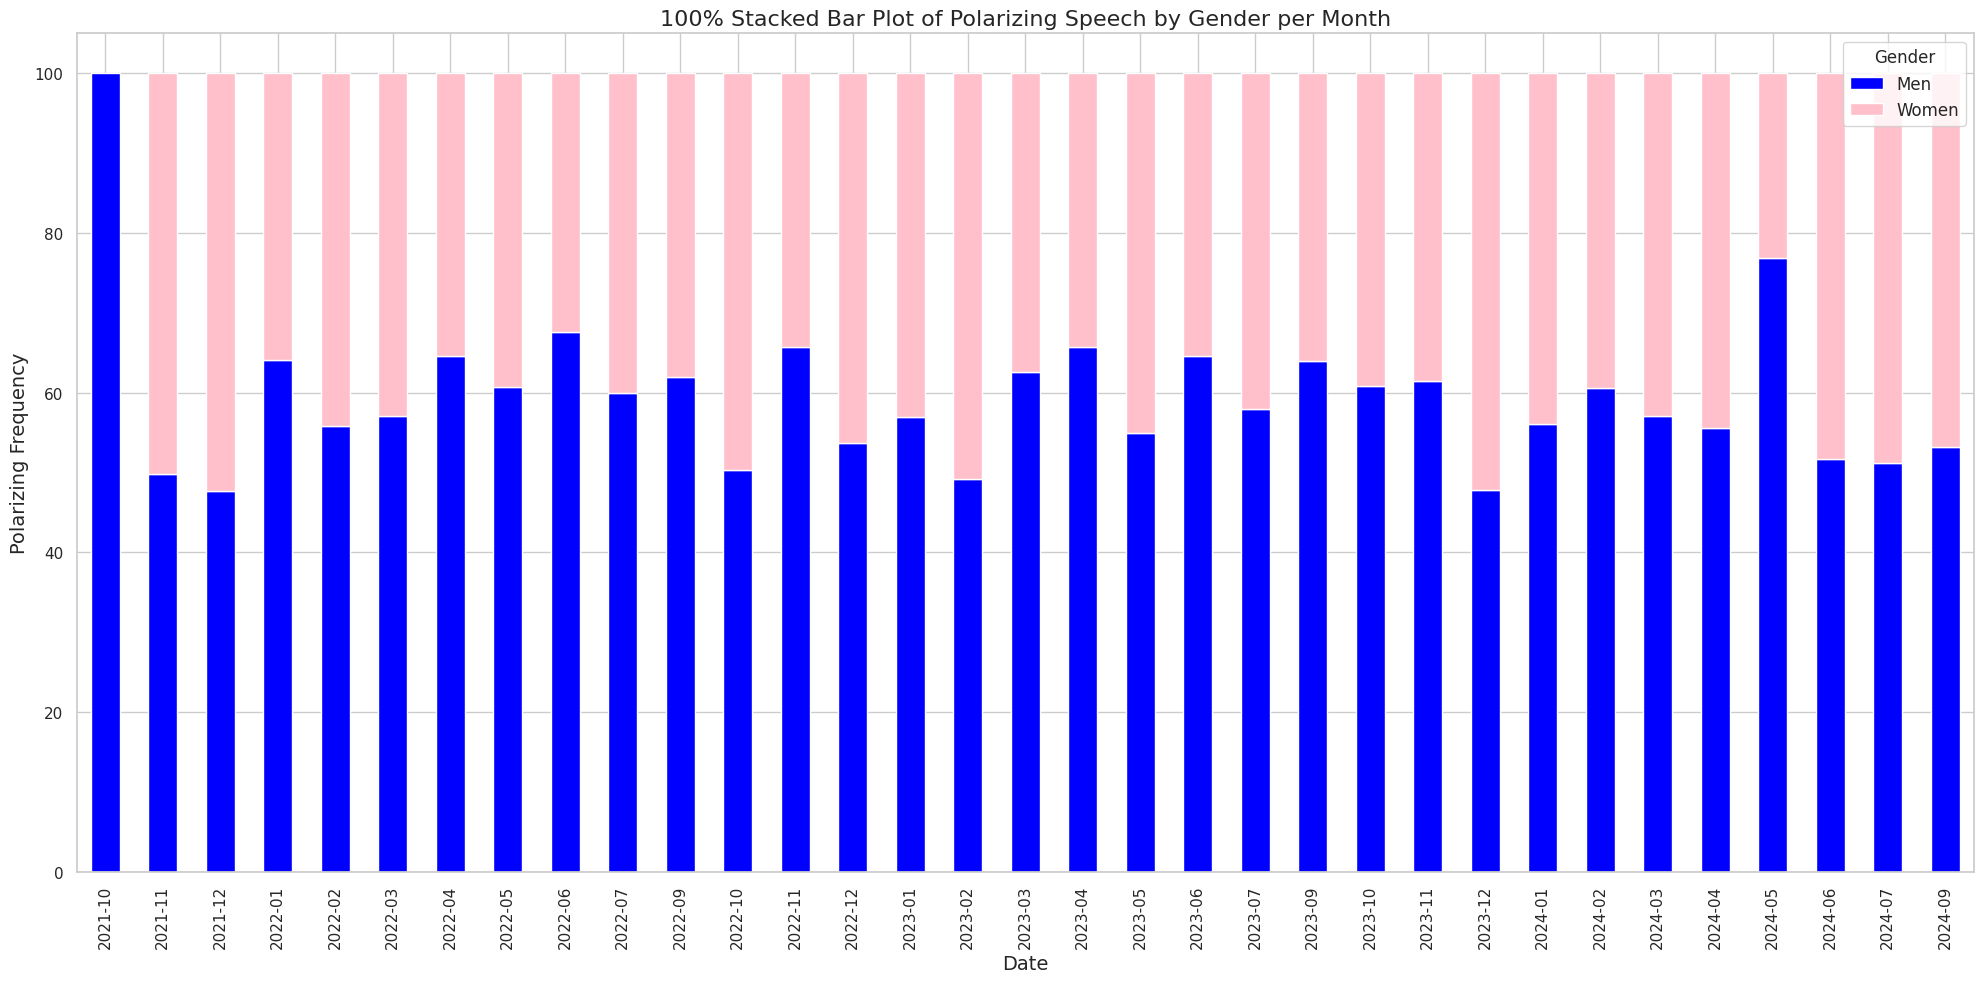

In [16]:
# Berechne die Summe der polarisierenden Reden und die Gesamtzahl der Reden pro Monat
features_with_polarization_20_grouped_gender_stacked = features_with_polarization_20.groupby(['month_year', 'gender']).agg({'polarizing': 'sum', 'id':'count'}).reset_index()

features_with_polarization_20_grouped_gender_stacked['polarizing_frequency'] = features_with_polarization_20_grouped_gender_stacked['polarizing']/features_with_polarization_20_grouped_gender_stacked['id']

features_pivot = features_with_polarization_20_grouped_gender_stacked.pivot(index='month_year', columns='gender', values='polarizing_frequency').fillna(0)

features_pivot_percent = features_pivot.div(features_pivot.sum(axis=1), axis=0) * 100

colors = ['blue', 'pink']

features_pivot_percent.plot(kind='bar', stacked=True, color=colors, figsize=(20, 10), width= 0.5)

plt.title('100% Stacked Bar Plot of Polarizing Speech by Gender per Month', fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Polarizing Frequency", fontsize=14)

plt.xticks(rotation=90)

plt.legend(title='Gender', labels=['Men', 'Women'], fontsize=12)


plt.tight_layout()
plt.show()


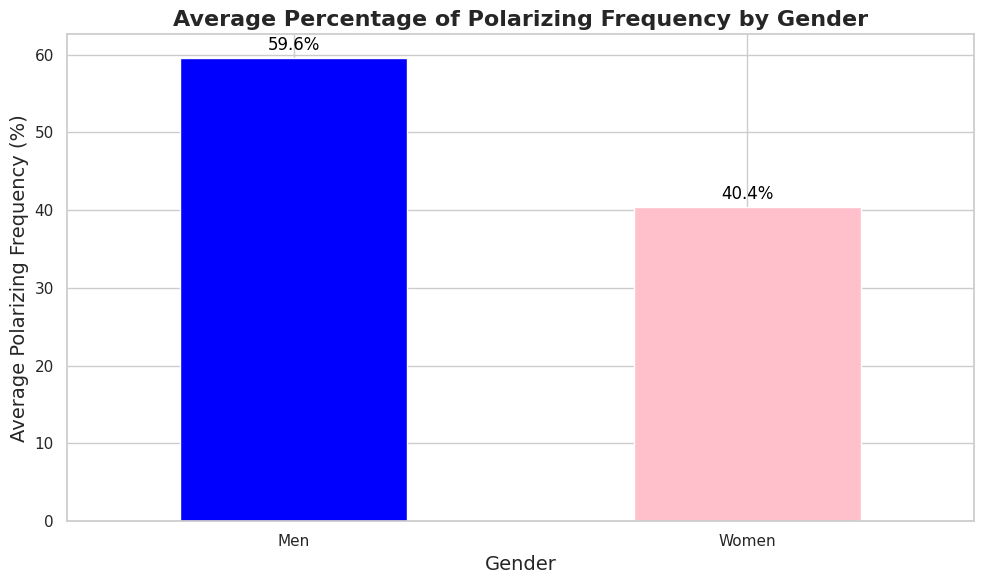

In [17]:
average_polarizing_percent = features_pivot_percent.mean()
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = average_polarizing_percent.plot(kind='bar', color=['blue', 'pink'], width=0.5)

plt.title('Average Percentage of Polarizing Frequency by Gender', fontsize=16,  weight='bold')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Average Polarizing Frequency (%)', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Men', 'Women'], rotation=0)

# Werte auf die Balken schreiben
for index, value in enumerate(average_polarizing_percent):
    plt.text(index, value + 1, f"{value:.1f}%", ha='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()


## 6.2 By Age

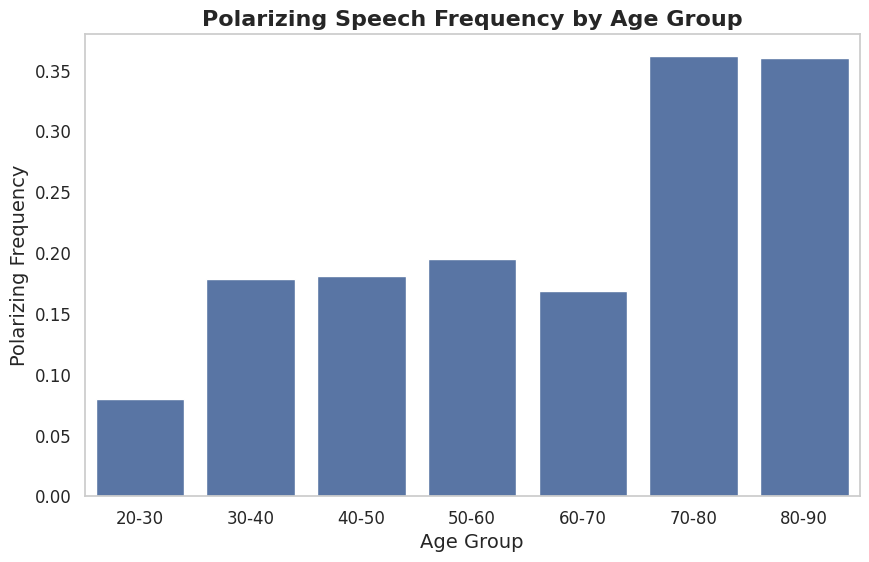

In [18]:
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
features_with_polarization_20['age_group'] = pd.cut(features_with_polarization_20['age'], bins=bins, labels=labels, right=False)

features_with_polarization_20_age = features_with_polarization_20.groupby('age_group').agg({
    'polarizing': 'sum',
    'id': 'count'
}).reset_index()

features_with_polarization_20_age['polarizing_frequency'] = (features_with_polarization_20_age['polarizing'] / features_with_polarization_20_age['id'])

features_with_polarization_20_age = features_with_polarization_20_age.sort_values(by='polarizing_frequency', ascending=False)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(data=features_with_polarization_20_age, x='age_group', y='polarizing_frequency')

plt.title("Polarizing Speech Frequency by Age Group", fontsize=16,  weight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Polarizing Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)
plt.show()


In [19]:
# Print the polarizing frequency for each age group
print(features_with_polarization_20_age[['age_group', 'polarizing_frequency']])


  age_group polarizing_frequency
5     70-80             0.361702
6     80-90             0.360656
3     50-60             0.195222
2     40-50              0.18096
1     30-40              0.17853
4     60-70             0.169106
0     20-30             0.079836


Anzahl der Politiker*innen pro Altersgruppe:
  age_group  unique_politicians
0     20-30                  45
1     30-40                 170
2     40-50                 254
3     50-60                 289
4     60-70                 152
5     70-80                  13
6     80-90                   2


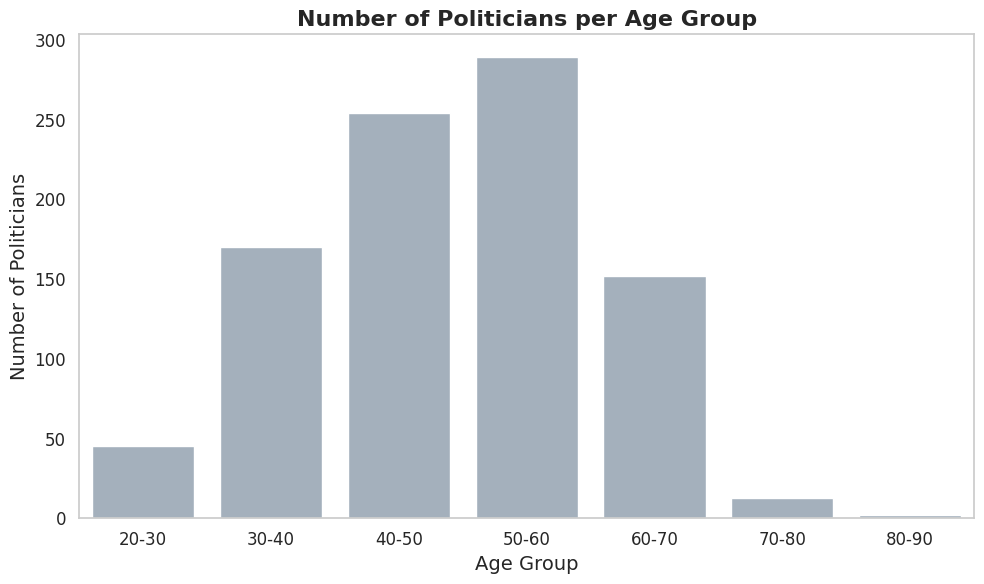

In [20]:
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
features_with_polarization_20['age_group'] = pd.cut(features_with_polarization_20['age'], bins=bins, labels=labels, right=False)

# Berechnung der Anzahl einzigartiger Politiker*innen pro Altersgruppe
politicians_per_age_group = features_with_polarization_20.groupby('age_group')['politician_id'].nunique().reset_index()
politicians_per_age_group = politicians_per_age_group.rename(columns={'politician_id': 'unique_politicians'})

# DataFrame ausgeben
print("Anzahl der Politiker*innen pro Altersgruppe:")
print(politicians_per_age_group)

# Visualisierung
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=politicians_per_age_group, x='age_group', y='unique_politicians', color='#A0B0C0')

plt.title("Number of Politicians per Age Group", fontsize=16,  weight='bold')
plt.xlabel("Age Group", fontsize=14)
plt.ylabel("Number of Politicians", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)
plt.tight_layout()
plt.show()


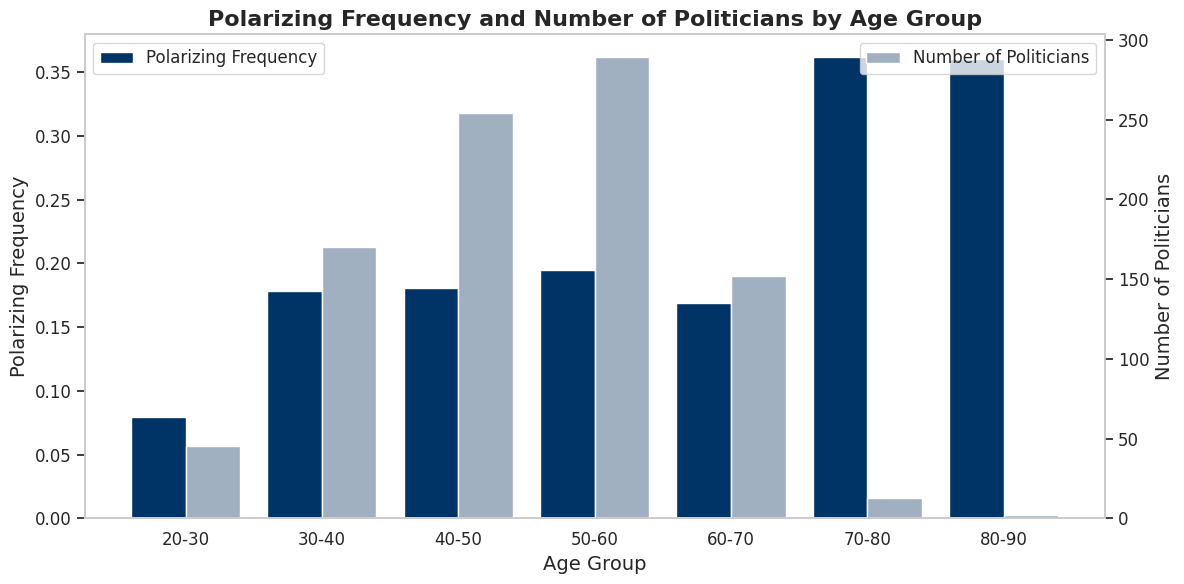

In [54]:
# Ensure age groups are ordered correctly (youngest to oldest)
features_with_polarization_20_age['age_group'] = pd.Categorical(
    features_with_polarization_20_age['age_group'],
    categories=labels,  # Ensure age groups follow the defined order
    ordered=True
)

politicians_per_age_group['age_group'] = pd.Categorical(
    politicians_per_age_group['age_group'],
    categories=labels,
    ordered=True
)

# Sort both datasets
features_with_polarization_20_age = features_with_polarization_20_age.sort_values('age_group')
politicians_per_age_group = politicians_per_age_group.sort_values('age_group')

# Set positions for the grouped bars
x = np.arange(len(features_with_polarization_20_age['age_group']))  # Label locations
width = 0.4  # Width of each bar

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar for Polarizing Frequency on the first y-axis
bar1 = ax1.bar(x - width/2, features_with_polarization_20_age['polarizing_frequency'], width,
               label='Polarizing Frequency', color='#003366')
ax1.set_xlabel('Age Group', fontsize=14)
ax1.set_ylabel('Polarizing Frequency', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(features_with_polarization_20_age['age_group'], fontsize=12)

# Create a second y-axis for the number of politicians
ax2 = ax1.twinx()
bar2 = ax2.bar(x + width/2, politicians_per_age_group['unique_politicians'], width,
               label='Number of Politicians', color='#A0B0C0')
ax2.set_ylabel('Number of Politicians', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax1.grid(False)  # Turn off grid for the first y-axis
ax2.grid(False)  # Turn off grid for the second y-axis

sns.set_theme(style="whitegrid")

# Title and legend
plt.title('Polarizing Frequency and Number of Politicians by Age Group', fontsize=16, weight='bold')
fig.tight_layout()

# Add legends for both axes
ax1.legend([bar1], ['Polarizing Frequency'], loc='upper left', fontsize=12)
ax2.legend([bar2], ['Number of Politicians'], loc='upper right', fontsize=12)

plt.show()


In [ ]:
politicians_per_age_group

,age_group,unique_politicians
0,20-30,45
1,30-40,170
2,40-50,254
3,50-60,289
4,60-70,152
5,70-80,13
6,80-90,2


In [ ]:
# Filtere Politiker*innen mit Alter > 70
politicians_per_age_group_filtered = features_with_polarization_20[features_with_polarization_20["age"] > 80]

# Wähle die eindeutigen Politiker*innen und deren zugehörige Spalten
unique_politicians_over_70 = politicians_per_age_group_filtered.drop_duplicates(subset=['politician_id'])

pd.set_option('display.max_columns', None)
unique_politicians_over_70

,id,electoral_term,session,first_name,document_url,last_name,faction_id,position_short,position_long,politician_id,top_item,top_title,speech_content,date,faction,year,speech_length,age,gender,tenure,topic,main_category,sub_category,Stadt,Former Country,City Classification,net_sentiment_score,positivity_sentiment,negativity_sentiment,polarizing,age_group
101425,1115727,20,17,alexander,https://dip21.bundestag.de/dip21/btp/20/20017.pdf,gauland,0,Member of Parliament,None,11004724,Tagesordnungspunkt 7,a) Antrag der Fraktion der CDU/CSU: Russlands ...,Frau Präsidentin! Meine Damen und Herren! Stel...,2022-02-17,AfD,2022,2842,81.0,männlich,4.243836,Außenpolitik: Ost-West Konflikt,Foreign Policy,Ost-West Konflikt,Chemnitz,former GDR,Large City,0.078431,0.181373,0.102941,False,80-90
111734,1086418,20,82,albrecht,https://dip21.bundestag.de/dip21/btp/20/20082.pdf,glaser,0,Member of Parliament,None,11004727,Zusatzpunkt 9,Aktuelle Stunde auf Verlangen der Fraktion der...,Herzlichen Dank. – Frau Präsidentin! Meine Dam...,2023-01-26,AfD,2023,5350,81.0,männlich,5.024658,Technologie: Digitalisierung,Technology,Digitalisierung,Worms,former BRD,Medium City,0.078481,0.139241,0.060759,True,80-90


In [ ]:
pd.reset_option('display.max_columns')


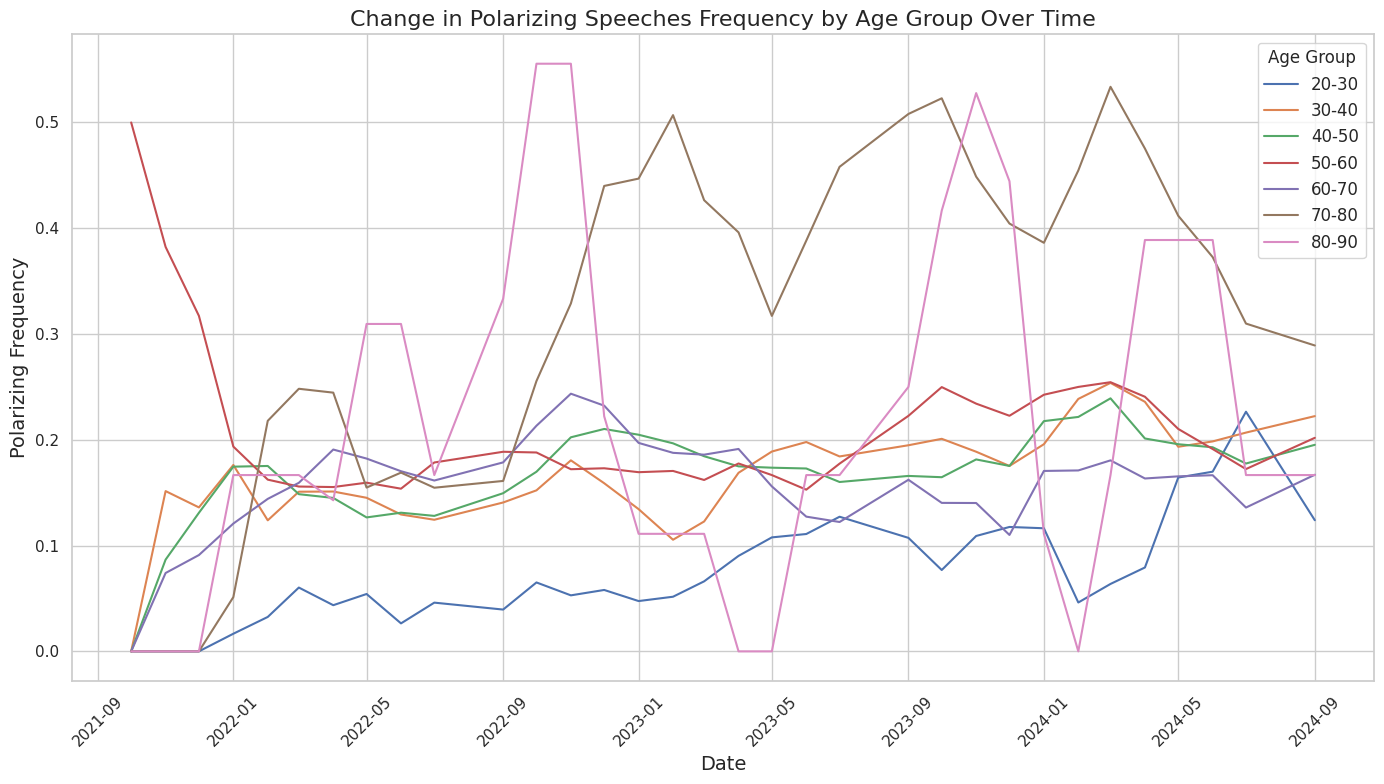

In [ ]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M')
features_with_polarization_20['month_year'] = features_with_polarization_20['month_year'].dt.to_timestamp()

features_with_polarization_20_age_time = features_with_polarization_20.groupby(['month_year', 'age_group']).agg({
    'polarizing': 'sum',
    'id': 'count'
}).reset_index()

features_with_polarization_20_age_time['id'] = features_with_polarization_20_age_time['id'].fillna(0)

features_with_polarization_20_age_time['polarizing_frequency_age'] = 0

mask = features_with_polarization_20_age_time['id'] > 0
features_with_polarization_20_age_time.loc[mask, 'polarizing_frequency_age'] = (
    features_with_polarization_20_age_time.loc[mask, 'polarizing'] / features_with_polarization_20_age_time.loc[mask, 'id']
)

features_with_polarization_20_age_time['polarizing_frequency_smooth'] = features_with_polarization_20_age_time.groupby('age_group')['polarizing_frequency_age'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
sns.set_theme(style="whitegrid")

plt.figure(figsize=(14, 8))
sns.lineplot(data=features_with_polarization_20_age_time, x='month_year', y='polarizing_frequency_smooth', hue='age_group', marker='')

plt.title("Change in Polarizing Speeches Frequency by Age Group Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Polarizing Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Age Group', fontsize=12)
plt.tight_layout()

plt.show()


# 7.Impact of Political Experience on Polarization

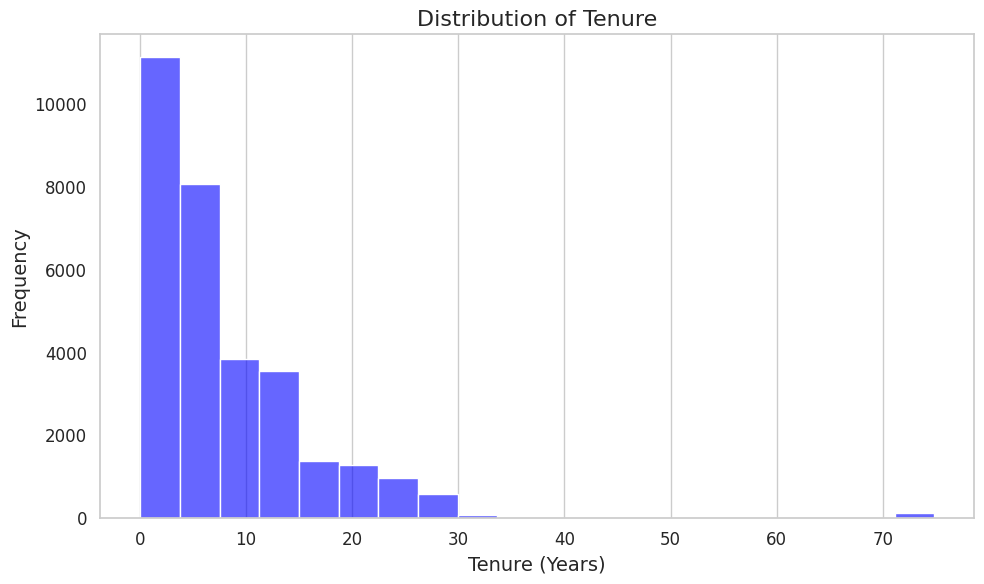

In [21]:
# plot distribution
features_with_polarization_20_tenure = features_with_polarization_20[['tenure', 'polarizing', 'speech_length', 'id']]
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Histogramm mit KDE
sns.histplot(data=features_with_polarization_20_tenure, x='tenure', bins=20, color='blue', alpha=0.6)

# Titel und Achsenbeschriftungen anpassen
plt.title("Distribution of Tenure", fontsize=16)
plt.xlabel("Tenure (Years)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)

# Plot anzeigen
plt.tight_layout()
plt.show()

In [22]:
features_with_polarization_20_tenure

,tenure,polarizing,speech_length,id
100032,7.704110,False,100,1066957
100033,7.704110,False,2425,1066959
100034,18.980822,False,3727,1066961
100035,15.780822,False,4241,1066963
100036,11.747945,False,4498,1066965
...,...,...,...,...
131053,2.701370,False,2870,1075918
131054,14.668493,True,3166,1075920
131055,6.594521,True,1799,1075922
131056,6.594521,False,12,1075924


In [23]:
# remove outliers

features_with_polarization_20_tenure_cleaned = features_with_polarization_20_tenure[features_with_polarization_20_tenure["tenure"] < 70]

In [24]:
features_with_polarization_20_tenure_cleaned = features_with_polarization_20_tenure_cleaned.groupby('tenure').agg({
    'polarizing': 'sum',
    'id': 'count'
}).reset_index()

features_with_polarization_20_tenure_cleaned['polarizing_frequency'] = features_with_polarization_20_tenure_cleaned['polarizing'] / features_with_polarization_20_tenure_cleaned['id']

correlation = features_with_polarization_20_tenure_cleaned[['tenure', 'polarizing_frequency']].corr(method='pearson')

print("Pearson correlation between tenure and polarizing_frequency:")
print(correlation)

Pearson correlation between tenure and polarizing_frequency:
                        tenure  polarizing_frequency
tenure                1.000000             -0.058336
polarizing_frequency -0.058336              1.000000


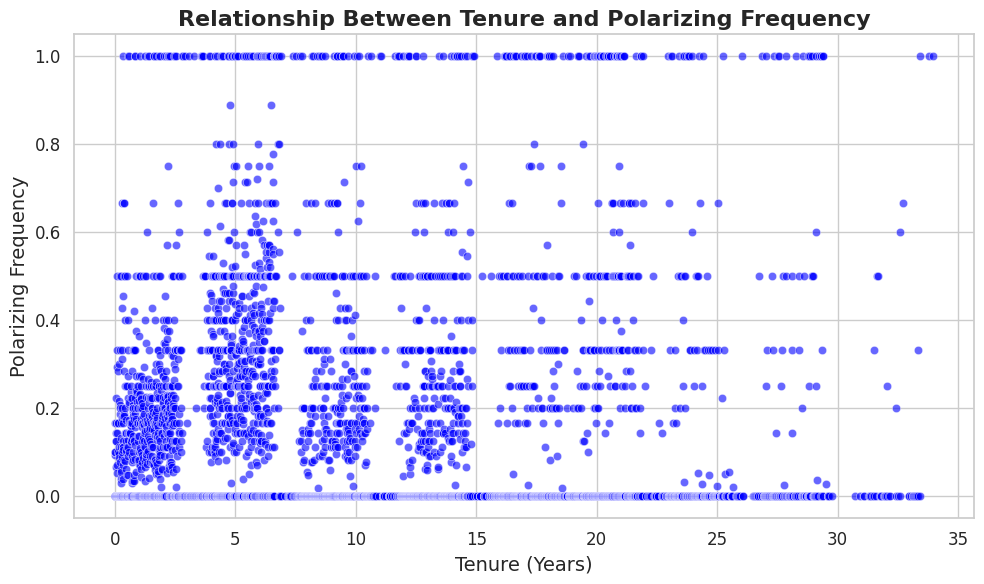

In [25]:
sns.set_theme(style="whitegrid")

# Erstellen eines Streudiagramms von Tenure vs. Polarizing Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features_with_polarization_20_tenure_cleaned, x='tenure', y='polarizing_frequency', color='blue', alpha=0.6)

# Hinzufügen einer linearen Regression zur Darstellung des Zusammenhangs
#sns.regplot(data=features_with_polarization_20_tenure_cleaned, x='tenure', y='polarizing_frequency', scatter=False, color='red')

# Titel und Achsenbeschriftungen anpassen
plt.title("Relationship Between Tenure and Polarizing Frequency", fontsize=16,  weight='bold')
plt.xlabel("Tenure (Years)", fontsize=14)
plt.ylabel("Polarizing Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

# Plot anzeigen
plt.tight_layout()
plt.show()


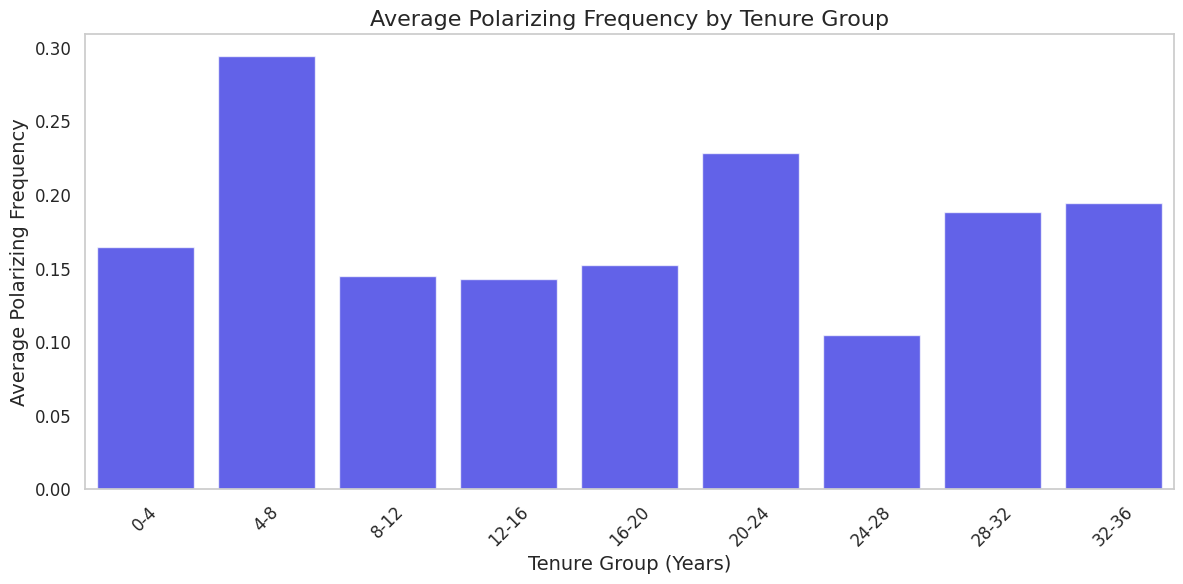

In [28]:
bins = range(0, int(features_with_polarization_20_tenure_cleaned['tenure'].max()) + 4, 4)
labels = [f"{i}-{i+4}" for i in bins[:-1]]
features_with_polarization_20_tenure_cleaned['tenure_group'] = pd.cut(features_with_polarization_20_tenure_cleaned['tenure'], bins=bins, labels=labels, right=False)

avg_polarization_per_group = features_with_polarization_20_tenure_cleaned.groupby('tenure_group')['polarizing_frequency'].mean().reset_index()
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_polarization_per_group, x='tenure_group', y='polarizing_frequency', color='blue', alpha=0.7)

plt.title("Average Polarizing Frequency by Tenure Group", fontsize=16)
plt.xlabel("Tenure Group (Years)", fontsize=14)
plt.ylabel("Average Polarizing Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="", alpha=0.7)

plt.tight_layout()
plt.show()


# 8. Polarizing Topics

In [6]:
features_with_polarization_20["main_category"].unique()

array(['no topic', 'Domestic Trade', 'Law & Crime', 'Work',
       'Public Administration', 'Social Policy', 'Defense Policy',
       'Agriculture', 'Energy', 'Civil Rights', 'Healthcare',
       'Foreign Policy', 'Transport', 'Environment', 'Housing',
       'Technology', 'Sports', 'Education', 'Economy', 'Foreign Trade',
       'Reunification'], dtype=object)

In [6]:
features_with_polarization_20["sub_category"].unique()

array([None, ' Verbraucherschutz', ' Korruption & Lobbyismus', ' Renten',
       ' Nahrungsmittel', ' Mindestlohn', ' Covid19',
       ' Flucht, Asyl & Einbürgerung', ' Naher Osten',
       ' Entwicklungspolitik', ' Flug', ' Europa', ' Tierschutz',
       ' Fossile Energie', ' Klima- & Umweltschutz', ' Geringverdiener',
       ' Digitalisierung', ' Dieselskandal', ' Ost-West Konflikt',
       ' Schule', ' Kinder & Jugenhilfe', ' Bürger:innenversicherunng',
       ' Steuern', ' Innerdeutscher Terrorismus', ' Föderalismus',
       ' Rundfunk', ' Erneuerbare Energie', ' Mittelstand',
       ' Nachkriegsordnung', ' Haushalt', ' Wirtschaftskriminalität',
       ' Globalisierung & Weltwirtschaft', ' Leih- & Zeitarbeit',
       ' Zivil und Strafrecht', ' Polizei & Grenzschutz', ' Forschung',
       ' Hochschule & Universität', ' Familienangelegenheiten',
       ' Kernenergie', ' Datenschutz', ' Bahn', ' Handelsabkommen',
       ' Militärische Unterstützung und Waffenlieferung',
       ' Ar

In [9]:
features_with_polarization_20["topic"].unique()

array(['No Topic', 'Binnenhandel: Verbraucherschutz',
       'Recht & Kriminalität', 'Arbeit',
       'Öffentliche Verwaltun: Korruption & Lobbyismus',
       'Sozialpolitik: Renten', 'Verteidigungspolitik',
       'Landwirtschaft: Nahrungsmittel', 'Energie', 'BürgerInnenrechte',
       'Arbeit: Mindestlohn', 'Öffentliche Verwaltung',
       'Gesundheitswesen: Covid19', 'Gesundheitswesen',
       'BürgerInnenrechte: Flucht, Asyl & Einbürgerung',
       'Außenpolitik: Naher Osten', 'Außenpolitik: Entwicklungspolitik',
       'Außenpolitik', 'Transport: Flug', 'Außenpolitik: Europa',
       'Landwirtschaft', 'Landwirtschaft: Tierschutz', 'Umwelt',
       'Energie: Fossile Energie', 'Umwelt: Klima- & Umweltschutz',
       'Wohnungswesen', 'Sozialpolitik: Geringverdiener',
       'Technologie: Digitalisierung', 'Umwelt: Dieselskandal',
       'Außenpolitik: Ost-West Konflikt', 'Transport', 'Sozialpolitik',
       'Sport', 'Bildung: Schule', 'Sozialpolitik: Kinder & Jugenhilfe',
       'So

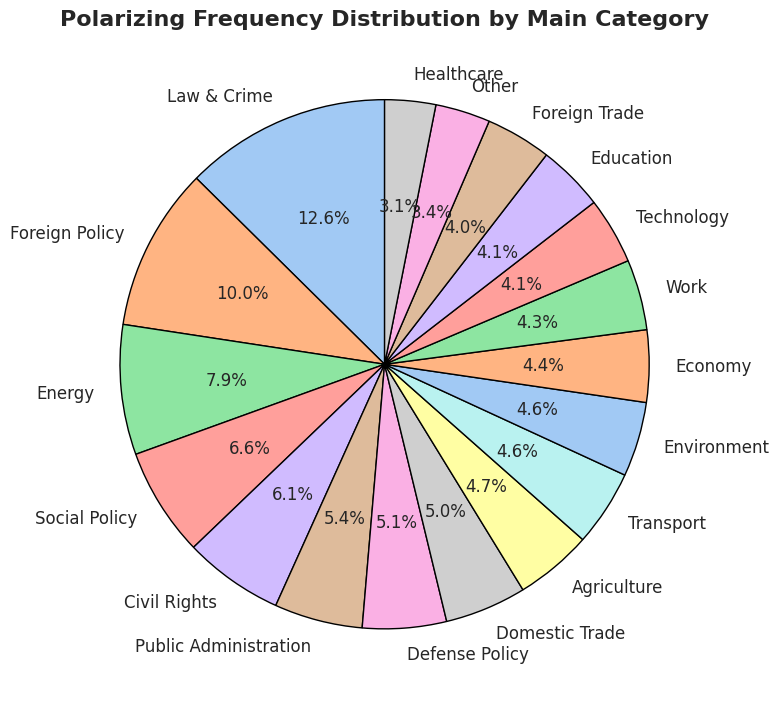

In [28]:
# Berechnung der Polarizing Frequency für jede main_category
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M').dt.to_timestamp()

features_with_polarization_20_filtered = features_with_polarization_20[features_with_polarization_20["topic"] != "No Topic"]

features_with_polarization_20_main_category = features_with_polarization_20_filtered.groupby(['month_year', 'topic', 'main_category']).agg({'polarizing': 'sum', 'id': 'count'}).reset_index()

features_with_polarization_20_main_category['polarizing_frequency'] = features_with_polarization_20_main_category['polarizing'] / features_with_polarization_20_main_category['id']

# Berechne die Summe der 'polarizing_frequency' für jede main_category
category_polarizing_sum = features_with_polarization_20_main_category.groupby('main_category')['polarizing_frequency'].sum().reset_index()

# Berechne die Gesamt-Summe der 'polarizing_frequency', um Prozentsatz zu berechnen
total_polarizing_frequency = category_polarizing_sum['polarizing_frequency'].sum()

# Berechne den Prozentsatz für jede Kategorie
category_polarizing_sum['percentage'] = (category_polarizing_sum['polarizing_frequency'] / total_polarizing_frequency) * 100

# Kategorien, die weniger als 4% ausmachen, zusammenfassen
other_category = category_polarizing_sum[category_polarizing_sum['percentage'] < 3]
other_category_sum = other_category['polarizing_frequency'].sum()

# Alle Kategorien, die mehr als 4% ausmachen
top_categories = category_polarizing_sum[category_polarizing_sum['percentage'] >= 3]

# Füge "Other" zu den Top-Kategorien hinzu
other_row = pd.DataFrame({'main_category': ['Other'],
                          'polarizing_frequency': [other_category_sum],
                          'percentage': [other_category_sum / total_polarizing_frequency * 100]})

# Kombiniere die Top-Kategorien mit der "Other"-Kategorie
top_categories = pd.concat([top_categories, other_row], ignore_index=True)

# Sortiere die Kategorien nach der 'polarizing_frequency' in absteigender Reihenfolge
top_categories = top_categories.sort_values(by='polarizing_frequency', ascending=False)

# Visualisierung als Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(top_categories['polarizing_frequency'],
        labels=top_categories['main_category'],
        autopct='%1.1f%%',  # Prozentanzeige
        startangle=90,
        colors=sns.color_palette("pastel", len(top_categories)),
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 12})  # Textformatierung

plt.title("Polarizing Frequency Distribution by Main Category", fontsize=16,  weight='bold')
plt.tight_layout()
plt.show()


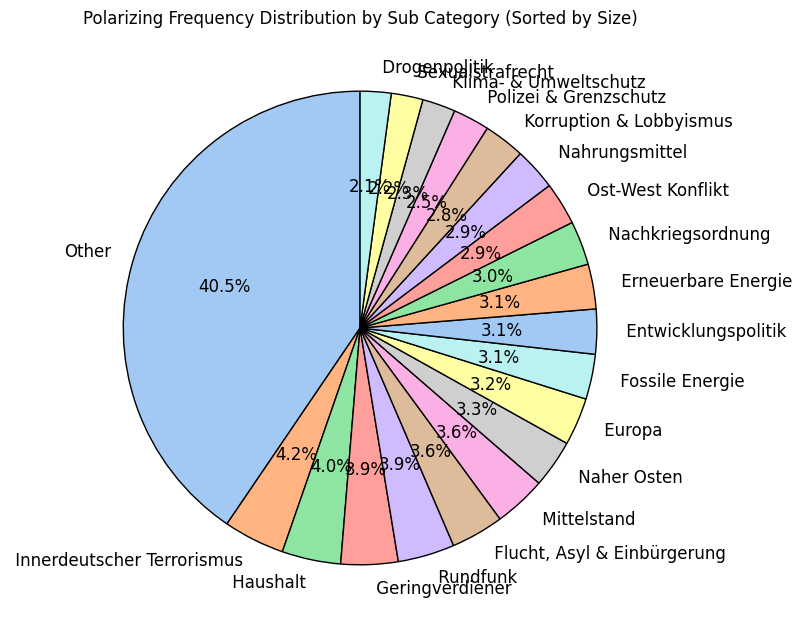

In [6]:
# Berechnung der Polarizing Frequency für jede sub_category
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M').dt.to_timestamp()

# Entfernen der Zeilen mit "No Topic"
features_with_polarization_20_filtered = features_with_polarization_20[features_with_polarization_20["topic"] != "No Topic"]

# Gruppiere nach 'month_year', 'topic' und 'sub_category'
features_with_polarization_20_sub_category = features_with_polarization_20_filtered.groupby(['month_year', 'topic', 'sub_category']).agg({'polarizing': 'sum', 'id': 'count'}).reset_index()

# Berechne die polarizing_frequency für jede sub_category
features_with_polarization_20_sub_category['polarizing_frequency'] = features_with_polarization_20_sub_category['polarizing'] / features_with_polarization_20_sub_category['id']

# Berechne die Summe der 'polarizing_frequency' für jede sub_category
category_polarizing_sum_sub = features_with_polarization_20_sub_category.groupby('sub_category')['polarizing_frequency'].sum().reset_index()

# Berechne die Gesamt-Summe der 'polarizing_frequency', um den Prozentsatz zu berechnen
total_polarizing_frequency_sub = category_polarizing_sum_sub['polarizing_frequency'].sum()

# Berechne den Prozentsatz für jede sub_category
category_polarizing_sum_sub['percentage'] = (category_polarizing_sum_sub['polarizing_frequency'] / total_polarizing_frequency_sub) * 100

# Kategorien, die weniger als 4% ausmachen, zusammenfassen
other_category_sub = category_polarizing_sum_sub[category_polarizing_sum_sub['percentage'] < 2]
other_category_sum_sub = other_category_sub['polarizing_frequency'].sum()

# Alle Kategorien, die mehr als 4% ausmachen
top_categories_sub = category_polarizing_sum_sub[category_polarizing_sum_sub['percentage'] >= 2]

# Füge "Other" zu den Top-Kategorien hinzu
other_row_sub = pd.DataFrame({'sub_category': ['Other'],
                              'polarizing_frequency': [other_category_sum_sub],
                              'percentage': [other_category_sum_sub / total_polarizing_frequency_sub * 100]})

# Kombiniere die Top-Kategorien mit der "Other"-Kategorie
top_categories_sub = pd.concat([top_categories_sub, other_row_sub], ignore_index=True)

# Sortiere die Kategorien nach der 'polarizing_frequency' in absteigender Reihenfolge
top_categories_sub = top_categories_sub.sort_values(by='polarizing_frequency', ascending=False)

# Visualisierung als Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(top_categories_sub['polarizing_frequency'],
        labels=top_categories_sub['sub_category'],
        autopct='%1.1f%%',  # Prozentanzeige
        startangle=90,
        colors=sns.color_palette("pastel", len(top_categories_sub)),
        wedgeprops={'edgecolor': 'black'},
        textprops={'fontsize': 12})  # Textformatierung

plt.title("Polarizing Frequency Distribution by Sub Category (Sorted by Size)")
plt.tight_layout()
plt.show()


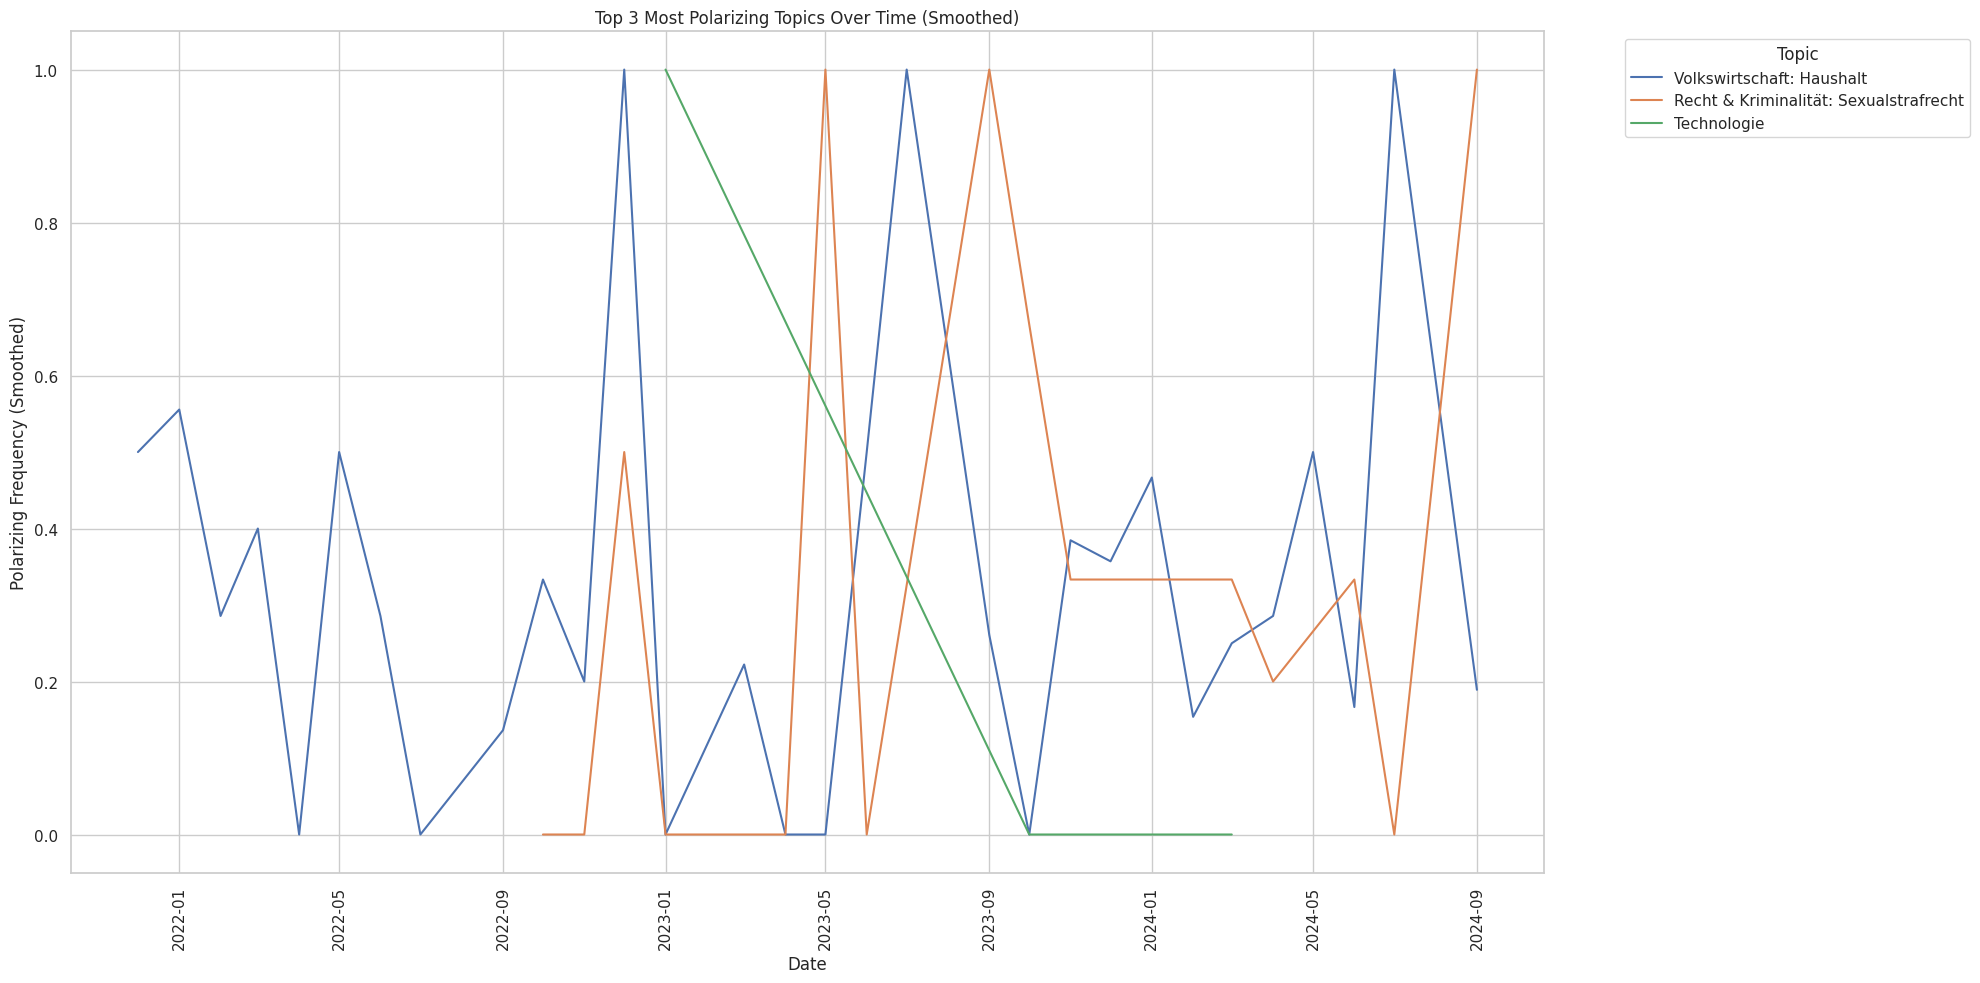

In [8]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M').dt.to_timestamp()

# Filter out rows with "No Topic"
features_with_polarization_20_filtered = features_with_polarization_20[features_with_polarization_20["topic"] != "No Topic"]

# Group by 'month_year' and 'topic' to calculate polarizing_frequency
features_with_polarization_20_topic = features_with_polarization_20_filtered.groupby(['month_year', 'topic']).agg({'polarizing': 'sum', 'id': 'count'}).reset_index()
features_with_polarization_20_topic['polarizing_frequency'] = features_with_polarization_20_topic['polarizing'] / features_with_polarization_20_topic['id']

# Ensure 'polarizing_frequency' is numeric
features_with_polarization_20_topic = features_with_polarization_20_topic.dropna(subset=['polarizing_frequency'])
features_with_polarization_20_topic['polarizing_frequency'] = pd.to_numeric(features_with_polarization_20_topic['polarizing_frequency'], errors='coerce')

# Compute the average polarizing frequency for each topic
avg_polarizing_frequency = features_with_polarization_20_topic.groupby('topic')['polarizing_frequency'].mean()

# Get the 3 most polarizing topics
top_3_topics_names = avg_polarizing_frequency.nlargest(3).index

# Filter data for the top 3 topics
top_3_topics = features_with_polarization_20_topic[features_with_polarization_20_topic['topic'].isin(top_3_topics_names)]

# Smooth the polarizing frequency using a rolling window
top_3_topics['polarizing_frequency_smooth'] = top_3_topics.groupby('topic')['polarizing_frequency'].transform(lambda x: x.rolling(window=1, min_periods=1).mean())

# Plot the smoothed trends
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=top_3_topics, x='month_year', y='polarizing_frequency_smooth', hue='topic')
plt.title("Top 3 Most Polarizing Topics Over Time (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Polarizing Frequency (Smoothed)")
plt.xticks(rotation=90)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [9]:
# comparison most polarizing topics first year compared to last year of electoral term
average_polarizing_frequency_all_time = top_3_topics.groupby('topic')['polarizing_frequency'].mean()

print(average_polarizing_frequency_all_time)


topic
Recht & Kriminalität: Sexualstrafrecht    0.335417
Technologie                                0.333333
Volkswirtschaft: Haushalt                  0.331120
Name: polarizing_frequency, dtype: float64


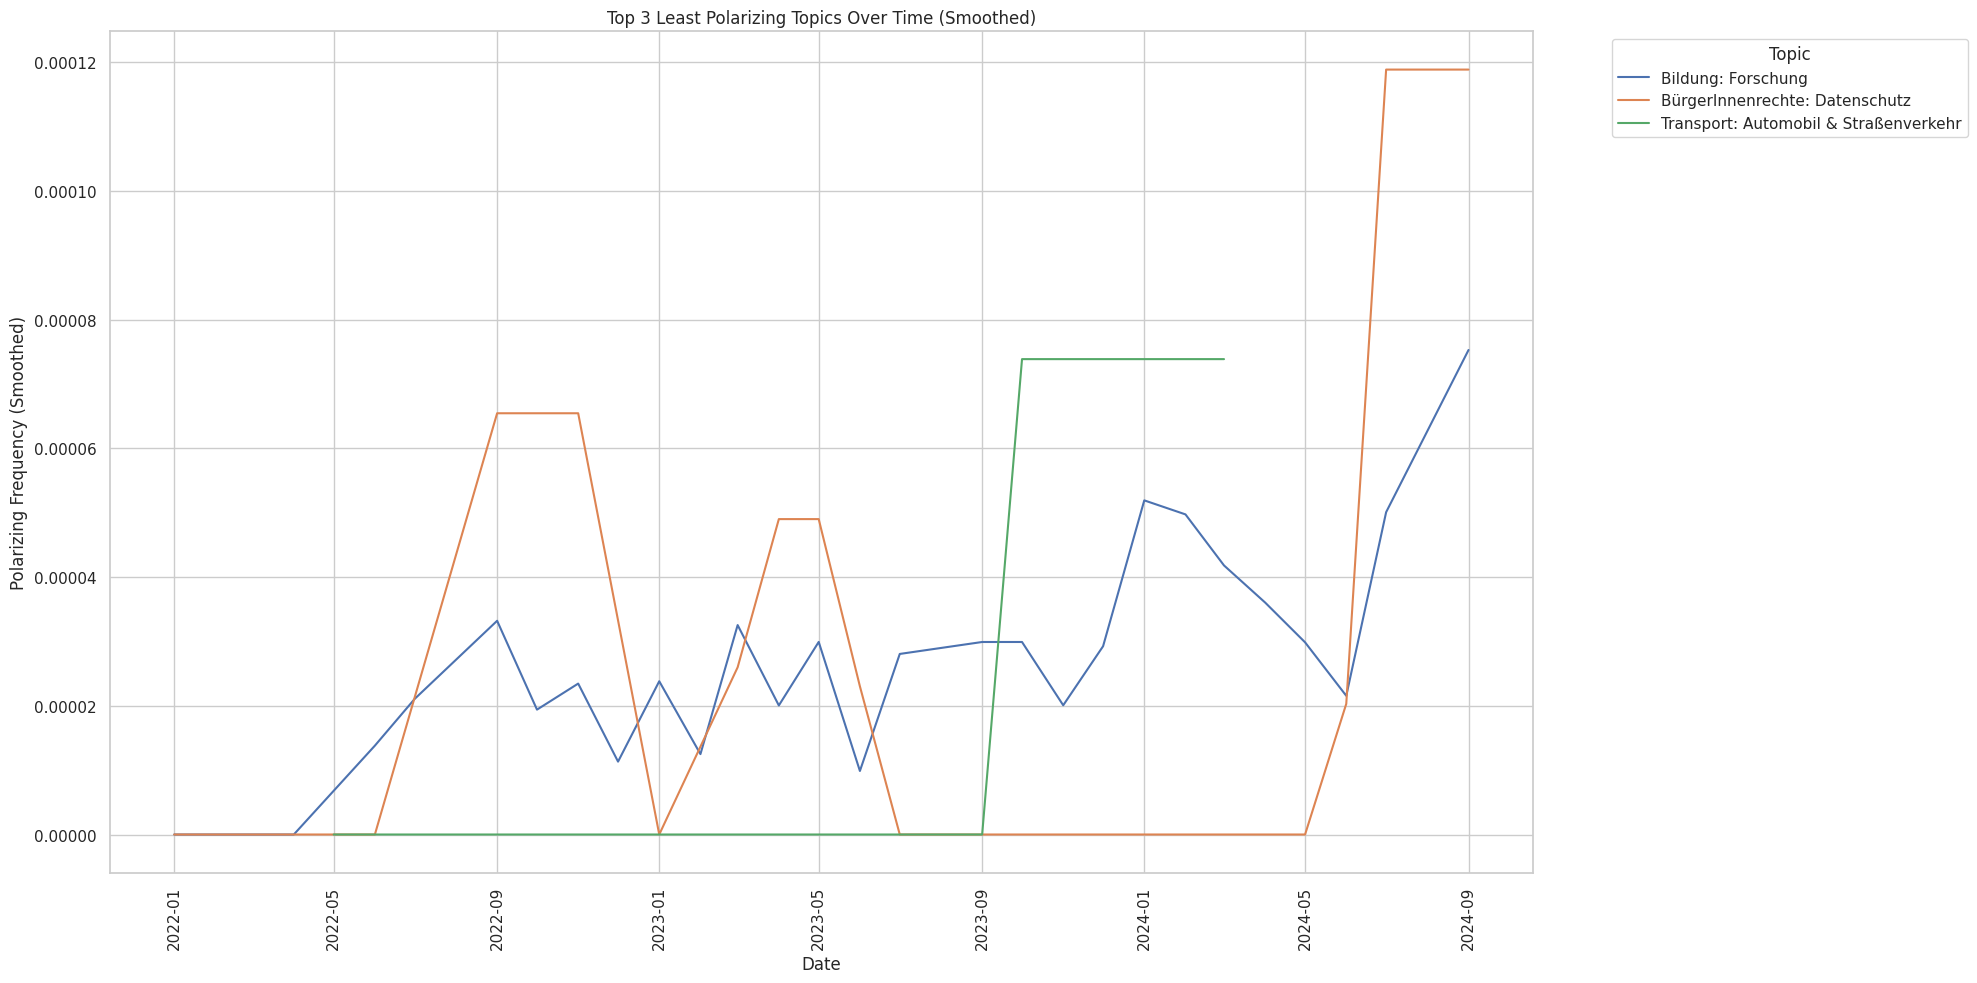

In [ ]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M').dt.to_timestamp()

# Filter out rows with "No Topic"
features_with_polarization_20_filtered = features_with_polarization_20[features_with_polarization_20["topic"] != "No Topic"]

# Group by 'month_year' and 'topic' to calculate polarizing_frequency
features_with_polarization_20_topic = features_with_polarization_20_filtered.groupby(['month_year', 'topic']).agg({'polarizing': 'sum', 'speech_length': 'sum'}).reset_index()
features_with_polarization_20_topic['polarizing_frequency'] = features_with_polarization_20_topic['polarizing'] / features_with_polarization_20_topic['speech_length']

# Ensure 'polarizing_frequency' is numeric
features_with_polarization_20_topic = features_with_polarization_20_topic.dropna(subset=['polarizing_frequency'])
features_with_polarization_20_topic['polarizing_frequency'] = pd.to_numeric(features_with_polarization_20_topic['polarizing_frequency'], errors='coerce')

# Compute the average polarizing frequency for each topic
avg_polarizing_frequency = features_with_polarization_20_topic.groupby('topic')['polarizing_frequency'].mean()

# Get the 3 least polarizing topics
bottom_3_topics_names = avg_polarizing_frequency.nsmallest(3).index

# Filter data for the bottom 3 topics
bottom_3_topics = features_with_polarization_20_topic[features_with_polarization_20_topic['topic'].isin(bottom_3_topics_names)]

# Smooth the polarizing frequency using a rolling window
bottom_3_topics['polarizing_frequency_smooth'] = bottom_3_topics.groupby('topic')['polarizing_frequency'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Plot the smoothed trends
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=bottom_3_topics, x='month_year', y='polarizing_frequency_smooth', hue='topic')
plt.title("Top 3 Least Polarizing Topics Over Time (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Polarizing Frequency (Smoothed)")
plt.xticks(rotation=90)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# comparison most polarizing topics first year compared to last year of electoral term
average_polarizing_frequency_all_time_bottom = bottom_3_topics.groupby('topic')['polarizing_frequency'].mean()

# Ausgabe der Ergebnisse
print(average_polarizing_frequency_all_time_bottom)

topic
Recht & Kriminalitä: Polizei & Grenzschutz    0.000155
Transport: Schifffahrt                         0.000186
Verteidigungspolitik: Rüstungskontrolle        0.000189
Name: polarizing_frequency, dtype: float64


In [11]:
features_with_polarization_20['month_year'] = pd.to_datetime(features_with_polarization_20['date']).dt.to_period('M').dt.to_timestamp()

# Filter out rows with "No Topic"
features_with_polarization_20_filtered = features_with_polarization_20[features_with_polarization_20["topic"] != "No Topic"]

# Identify the first and last year in the data
first_year = features_with_polarization_20_filtered['month_year'].min().year
last_year = features_with_polarization_20_filtered['month_year'].max().year

# Extract data for the first and last year
data_first_year = features_with_polarization_20_filtered[features_with_polarization_20_filtered['month_year'].dt.year == first_year]
data_last_year = features_with_polarization_20_filtered[features_with_polarization_20_filtered['month_year'].dt.year == last_year]

# Group by topic and calculate polarizing frequency for each year
data_first_year = data_first_year.groupby('topic').agg({'polarizing': 'sum', 'id': 'count'}).reset_index()
data_first_year['polarizing_frequency'] = data_first_year['polarizing'] / data_first_year['id']

data_last_year = data_last_year.groupby('topic').agg({'polarizing': 'sum', 'id': 'count'}).reset_index()
data_last_year['polarizing_frequency'] = data_last_year['polarizing'] / data_last_year['id']

# Ensure 'polarizing_frequency' is numeric
data_first_year['polarizing_frequency'] = pd.to_numeric(data_first_year['polarizing_frequency'], errors='coerce')
data_last_year['polarizing_frequency'] = pd.to_numeric(data_last_year['polarizing_frequency'], errors='coerce')

# Calculate average polarizing frequency for each topic
avg_polarizing_first_year = data_first_year.set_index('topic')['polarizing_frequency']
avg_polarizing_last_year = data_last_year.set_index('topic')['polarizing_frequency']

# Find the top 3 polarizing topics for each year
top_3_first_year = avg_polarizing_first_year.nlargest(3)
top_3_last_year = avg_polarizing_last_year.nlargest(3)

print("Top 3 Most Polarizing Topics in the First Year:")
print(top_3_first_year)
print("\nTop 3 Most Polarizing Topics in the Last Year:")
print(top_3_last_year)

# Combine results into a single DataFrame for comparison
top_3_comparison = pd.DataFrame({
    'First Year': top_3_first_year,
    'Last Year': top_3_last_year
}).reset_index()


Top 3 Most Polarizing Topics in the First Year:
topic
Außenpolitik                                         1.000000
Recht & Kriminalität: Innerdeutscher Terrorismus    0.666667
Außenpolitik: Europa                                 0.500000
Name: polarizing_frequency, dtype: float64

Top 3 Most Polarizing Topics in the Last Year:
topic
Außenpolitik                               0.500000
Verteidigungspolitik: Rüstungskontrolle    0.500000
Technologie: Rundfunk                      0.431818
Name: polarizing_frequency, dtype: float64


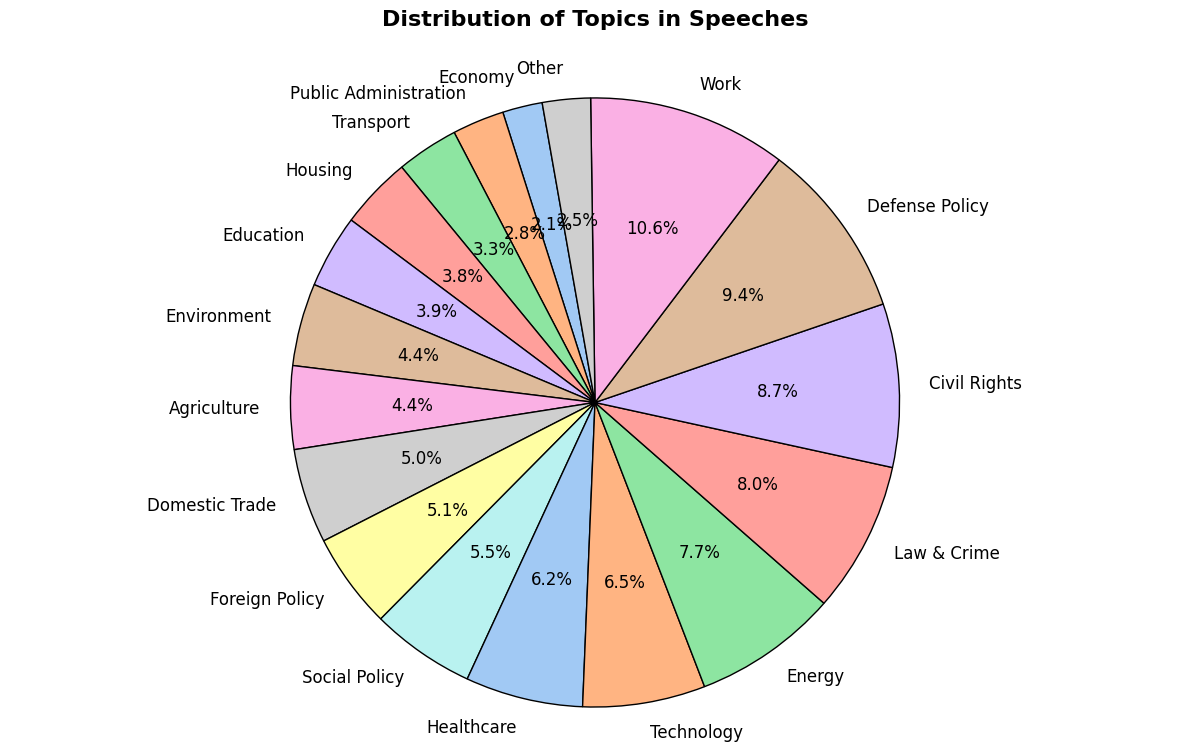

In [7]:
# Filter out "no topic" and calculate category percentages
speeches_with_sentiment_topics_without_no_topic = features_with_polarization_20[features_with_polarization_20['main_category'] != 'no topic']
category_counts = speeches_with_sentiment_topics_without_no_topic['main_category'].value_counts()
total_count = category_counts.sum()

# Group categories with less than 2% into "Other"
threshold = 0.02 * total_count  # Threshold for grouping
category_counts_grouped = category_counts.copy()
category_counts_grouped['Other'] = category_counts_grouped[category_counts_grouped < threshold].sum()
category_counts_grouped = category_counts_grouped[category_counts_grouped >= threshold]

# Place "Other" at the end
category_counts_grouped = category_counts_grouped.sort_values(ascending=True)
if 'Other' in category_counts_grouped.index:
    other_value = category_counts_grouped['Other']
    category_counts_grouped = category_counts_grouped.drop('Other')
    category_counts_grouped['Other'] = other_value

# Labels for the pie chart
labels = category_counts_grouped.index

# Plot the pie chart
plt.figure(figsize=(12, 8))
colors = sns.color_palette('pastel', len(category_counts_grouped))  # Use a pastel color palette
wedges, texts, autotexts = plt.pie(
    category_counts_grouped,
    labels=labels,
    autopct='%1.1f%%',
    startangle=100,
    colors=colors,
    wedgeprops={'edgecolor': 'black'},  # Add black borders for better separation
    textprops={'fontsize': 12}  # Adjust text size for readability
)

# Add a title and styling
plt.title('Distribution of Topics in Speeches', fontsize=16, weight='bold', y=1.05)  # Add more space between the title and the chart
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent label/title overlap

# save plot
plt.savefig('topic_distribution.png', dpi=300)
# Show the plot
plt.show()

In [9]:
# Berechnung der Anzahl polarizing und non-polarizing Reden pro Kategorie
category_polarization_split = features_with_polarization_20.groupby(['main_category', 'polarizing']).agg({'id': 'count'}).reset_index()

# Umbenennen der Spalten für Klarheit
category_polarization_split.rename(columns={'id': 'speech_count'}, inplace=True)

# Gesamte Anzahl an Reden pro Kategorie berechnen
total_speeches_per_category = category_polarization_split.groupby('main_category')['speech_count'].sum().reset_index()
total_speeches_per_category.rename(columns={'speech_count': 'total_speeches'}, inplace=True)

# Merge: Anteil pro Kategorie berechnen
category_polarization_split = pd.merge(category_polarization_split, total_speeches_per_category, on='main_category')
category_polarization_split['percentage'] = (category_polarization_split['speech_count'] / category_polarization_split['total_speeches']) * 100

# Pivot-Tabelle erstellen für besseren Überblick (optional)
polarization_table = category_polarization_split.pivot(index='main_category', columns='polarizing', values=['speech_count', 'percentage']).fillna(0)

# Spalten umbenennen für Lesbarkeit
polarization_table.columns = ['non_polarizing_count', 'polarizing_count', 'non_polarizing_percentage', 'polarizing_percentage']
polarization_table = polarization_table.reset_index()

# Sortieren nach dem Anteil der polarizing Speeches
polarization_table = polarization_table.sort_values(by='polarizing_percentage', ascending=False)

# Tabelle anzeigen
polarization_table


,main_category,non_polarizing_count,polarizing_count,non_polarizing_percentage,polarizing_percentage
1,Civil Rights,1537.0,548.0,73.717026,26.282974
6,Energy,1380.0,468.0,74.675325,25.324675
12,Law & Crime,1476.0,455.0,76.437079,23.562921
11,Housing,715.0,207.0,77.548807,22.451193
15,Social Policy,1033.0,297.0,77.669173,22.330827
3,Domestic Trade,943.0,267.0,77.933884,22.066116
4,Economy,399.0,110.0,78.388998,21.611002
8,Foreign Policy,959.0,260.0,78.671042,21.328958
0,Agriculture,844.0,218.0,79.472693,20.527307
13,Public Administration,527.0,136.0,79.487179,20.512821


In [11]:
# Filter für die Top 10 Kategorien mit dem höchsten Anteil an polarizing Speeches
top_10_polarized_categories = polarization_table.head(10)

# Tabelle anzeigen
top_10_polarized_categories


,main_category,non_polarizing_count,polarizing_count,non_polarizing_percentage,polarizing_percentage
1,Civil Rights,1537.0,548.0,73.717026,26.282974
6,Energy,1380.0,468.0,74.675325,25.324675
12,Law & Crime,1476.0,455.0,76.437079,23.562921
11,Housing,715.0,207.0,77.548807,22.451193
15,Social Policy,1033.0,297.0,77.669173,22.330827
3,Domestic Trade,943.0,267.0,77.933884,22.066116
4,Economy,399.0,110.0,78.388998,21.611002
8,Foreign Policy,959.0,260.0,78.671042,21.328958
0,Agriculture,844.0,218.0,79.472693,20.527307
13,Public Administration,527.0,136.0,79.487179,20.512821


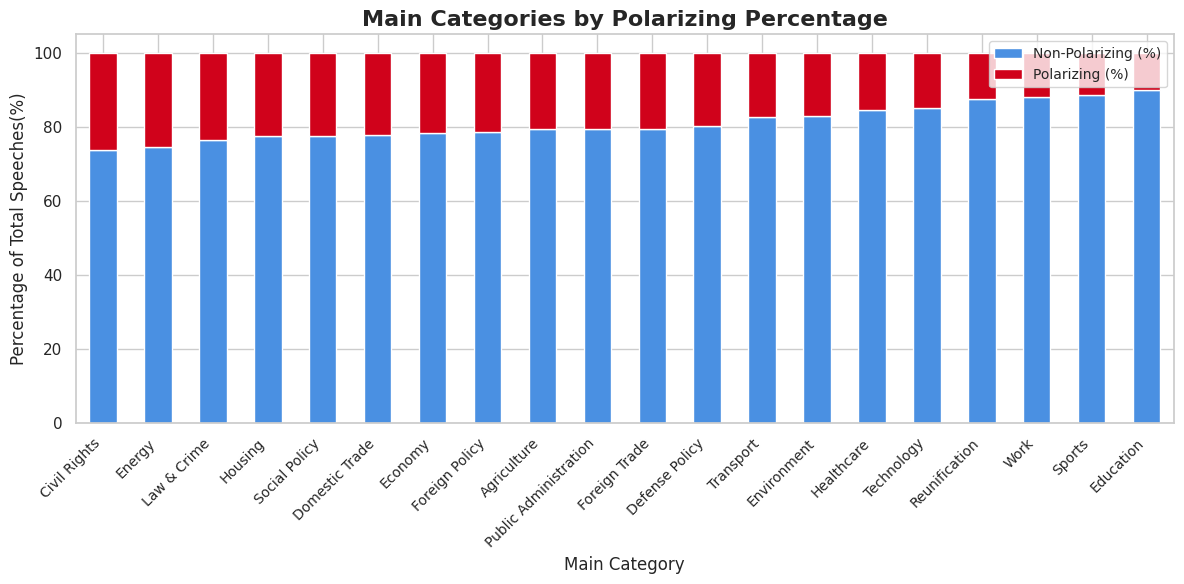

In [22]:
polarized_categories_filtered = polarization_table[polarization_table["main_category"] != "no topic"]

top_10_polarized_categories = polarized_categories_filtered.sort_values(by='polarizing_percentage', ascending=False)

# Setze die Hauptkategorien als Index
top_10_polarized_categories.set_index('main_category', inplace=True)

# Erstelle das gestapelte Balkendiagramm mit Blau und Rot
colors = sns.color_palette("muted", 10)  # Palette mit mehreren Farben
blue = "#4A90E2"  # Blau für non-polarizing
red = "#D0021B"   # Rot für polarizing

top_10_polarized_categories[['non_polarizing_percentage', 'polarizing_percentage']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=[blue, red],  # Blau für non-polarizing, Rot für polarizing
)

# Diagramm-Details hinzufügen
sns.set_theme(style="whitegrid")
plt.title('Main Categories by Polarizing Percentage', fontsize=16, weight='bold')
plt.ylabel('Percentage of Total Speeches(%)', fontsize=12)
plt.xlabel('Main Category', fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.legend(['Non-Polarizing (%)', 'Polarizing (%)'], fontsize=10)
plt.tight_layout()

# Diagramm anzeigen
plt.show()
